In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/learning/nus/cs5260/project'
data_path = root_path + '/data'
best_model_path = root_path + '/best_models'
output_path = root_path + '/outputs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Extraction
TODO:
1. Further clean spam emails that contain obvious content or metadata signaling that they are spam.

In [ ]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
NO_EXPERIMENTS = 1

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Loop throught each csv file in the data folder
# Concat all dataframes into a single dataframe
# Create a new column called 'source' and store filename into it
# Save the dataframe to a new csv file in the data folder
dfs = []
for filename in os.listdir(data_path + '/cleaned'):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_path + '/cleaned', filename))
        df.drop_duplicates(subset=['text', 'spam'], inplace=True)
        print(filename)
        print('Total:', df.shape[0], 'Non-spam:', df[df['spam'] == 0].shape[0], 'Spam:', df[df['spam'] == 1].shape[0])
        df['source'] = filename
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

assassin.csv
Total: 5295 Non-spam: 3998 Spam: 1297
ling.csv
Total: 2842 Non-spam: 2376 Spam: 466
enron.csv
Total: 28326 Non-spam: 14489 Spam: 13837
kaggle.csv
Total: 5439 Non-spam: 4089 Spam: 1350


In [ ]:
duplicate_emails = df[df.duplicated(subset='text', keep=False)]
duplicate_emails.sort_values(by='text')

,text,original_text,spam,source
16569,"! gorgeous , custom websites - $ 39 ##9 comple...","! gorgeous , custom websites - $ 399 complete ...",1,enron.csv
37643,"! gorgeous , custom websites - $ 39 ##9 comple...","! gorgeous , custom websites - $ 399 complete ...",1,kaggle.csv
37635,""" content - type : text / plain ; char ##set =...",""" content - type : text / plain ; charset = ""...",1,kaggle.csv
16379,""" content - type : text / plain ; char ##set =...",""" content - type : text / plain ; charset = "" ...",1,enron.csv
39921,""" en ##ron day "" to be declared in spear ##man...",""" enron day "" to be declared in spearman , tex...",0,kaggle.csv
...,...,...,...,...
38192,z ##inga ##les seminar f ##yi ! - - - - - - - ...,zingales seminar fyi ! - - - - - - - - - - -...,0,kaggle.csv
39832,z ##inga ##les seminar f ##yi ! - - - - - - - ...,zingales seminar fyi ! - - - - - - - - - - -...,0,kaggle.csv
16011,z ##inga ##les seminar f ##yi ! - - - - - - - ...,zingales seminar fyi !\n- - - - - - - - - - - ...,0,enron.csv
37961,zero curve generator for uk gil ##ts an ##ja #...,"zero curve generator for uk gilts anjam , he...",0,kaggle.csv


In [ ]:
duplicate_emails['source'].value_counts()

source
enron.csv       5413
kaggle.csv      5412
assassin.csv       1
Name: count, dtype: int64

In [ ]:
print('Before dropping duplicate emails:', df.shape[0])
df.drop_duplicates(subset=['text'], inplace=True)
print('After dropping duplicate emails:', df.shape[0])

Before dropping duplicate emails: 41902
After dropping duplicate emails: 36489


In [ ]:
df = df[~df['text'].str.contains('html body')]

In [ ]:
df['spam'].value_counts()

spam
0    20888
1    15584
Name: count, dtype: int64

In [ ]:
df.to_csv(os.path.join(data_path, 'preprocessed/raw_all.csv'), index=False)

In [ ]:
df = df[['text', 'spam']].copy()

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['spam'], test_size=0.1, random_state=42)

In [ ]:
df.shape, X_train.shape, X_val.shape

((36472, 2), (32824,), (3648,))

In [ ]:
y_val[y_val == 0].shape, y_val[y_val == 1].shape

((2098,), (1550,))

In [ ]:
vectorizer = TfidfVectorizer()
train_tfidf_matrix = vectorizer.fit_transform(X_train)
train_tfidf_df = pd.DataFrame(train_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

dump(vectorizer, os.path.join(root_path, 'tfidf_vectorizer.joblib'))

['/content/drive/MyDrive/learning/nus/cs5260/project/tfidf_vectorizer.joblib']

# Datasets & Loaders

## TF-IDF

In [ ]:
class TFIDFDataset(Dataset):
    def __init__(self, features_df, labels_df):
        self.features = torch.tensor(features_df.values, dtype=torch.float32)
        self.labels = torch.tensor(labels_df.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
val_tfidf_df = pd.DataFrame(vectorizer.transform(X_val).toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
BATCH_SIZE = 256

train_loader = DataLoader(TFIDFDataset(train_tfidf_df, y_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TFIDFDataset(val_tfidf_df, y_val), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
crafted_spam_samples = pd.read_csv(os.path.join(output_path, 'crafted_spam_samples.csv'))
crafted_spam_samples['spam'] = 1

X_train_crafted, X_val_crafted, y_train_crafted, y_val_crafted = train_test_split(crafted_spam_samples['adversarial_sample'], crafted_spam_samples['spam'], test_size=0.5, random_state=42)

# Models

## MLPs

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.5):
        super(MLPBlock, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.dropout(x)
        return x

class MLP(nn.Module):
    def __init__(self, input_size, neurons, best_model_path, dropout_rate=0.5, name=None):
        super(MLP, self).__init__()

        self.blocks = nn.ModuleList()
        self.name = f'mlp_{len(neurons) + 1}'
        if name is not None:
            self.name = name
        self.best_model_path = best_model_path

        # Create MLP blocks based on the 'neurons' list
        layer_sizes = [input_size] + neurons
        for i in range(1, len(layer_sizes)):
            block = MLPBlock(layer_sizes[i-1], layer_sizes[i], dropout_rate)
            self.blocks.append(block)

        # Output layer
        self.output = nn.Linear(layer_sizes[-1], 1)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.output(x)
        x = torch.sigmoid(x)  # Sigmoid activation to get probabilities
        return x

    def get_model_path(self, overrided_name=None):
        return os.path.join(self.best_model_path, overrided_name if overrided_name else self.name + '.pt')

    def load(self, overrided_name=None):
        self.load_state_dict(torch.load(self.get_model_path(overrided_name)))
        self.to(device)

    def save(self, overrided_name=None):
        torch.save(self.state_dict(), self.get_model_path(overrided_name))


In [ ]:
def compute_correct_predictions(y, logits):
    preds = logits >= 0.5
    correct_predictions = (preds == y).sum().item()
    return correct_predictions

def run_epoch(model, loader, attack=None, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    criterion = nn.BCELoss(reduction='sum')

    total_loss = 0
    correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, (inputs, labels) in bar:
            inputs, labels = inputs.to(device), labels.to(device)

            if attack is not None:
                model.eval()
                deltas = attack(model, inputs, labels, **kwargs)
                inputs = inputs + deltas

            if opt:
                model.train()
            else:
                model.eval()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            if opt:
                opt.zero_grad()
                loss.backward()
                opt.step()

            total_loss += loss.item()
            correct_predictions += compute_correct_predictions(labels, outputs)

    accuracy = correct_predictions / len(loader.dataset)
    loss = total_loss / len(loader.dataset)

    return accuracy, loss

def train_epoch_with_clean_mix(model, loader, attack, opt, k_ratio=0.5, adversarial_weight=0.3, description="Training   ", **kwargs):
    criterion = nn.BCELoss(reduction='sum')

    total_loss = 0
    correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, (inputs, labels) in bar:
            inputs, labels = inputs.to(device), labels.to(device)

            total_samples = inputs.shape[0]
            k = int(k_ratio * total_samples)
            indices = torch.randperm(total_samples)
            adversarial_indices = indices[:k]
            clean_indices = indices[k:]

            adversarial_samples = inputs[adversarial_indices]
            adversarial_labels = labels[adversarial_indices]
            clean_samples = inputs[clean_indices]
            clean_labels = labels[clean_indices]

            model.eval()
            deltas = attack(model, adversarial_samples, adversarial_labels, **kwargs)
            adversarial_samples += deltas

            model.train()
            adversarial_outputs = model(adversarial_samples).squeeze()
            adversarial_loss = criterion(adversarial_outputs, adversarial_labels)

            clean_outputs = model(clean_samples).squeeze()
            clean_loss = criterion(clean_outputs, clean_labels)

            loss = (adversarial_weight * adversarial_loss + clean_loss) / (total_samples - k + adversarial_weight * k)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item() * total_samples
            correct_predictions += compute_correct_predictions(torch.concat([adversarial_labels, clean_labels]), torch.concat([adversarial_outputs, clean_outputs]))

    accuracy = correct_predictions / len(loader.dataset)
    loss = total_loss / len(loader.dataset)

    return accuracy, loss

def embed(sample):
    tfidf = vectorizer.transform([' '.join(tokenizer.tokenize(sample))])
    df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    return torch.tensor(df.to_numpy()).float().to(device)

def validate_with_crafted_spam_samples(model, spam_samples, transform, description='', **kwargs):
    model.eval()

    correct_predictions = 0

    for spam_sample in spam_samples:
        input = transform(spam_sample)
        output = model(input)
        correct_predictions += (output > 0.5).item()

    accuracy = correct_predictions / len(spam_samples)

    return accuracy

def run_experiments(model, train_loader, valid_loader, crafted_spam_samples, attack=None, num_epochs=5, lr=0.003, weight_decay=1e-5, with_clean_mix=False, **kwargs):
    model.to(device)
    best_val_accuracy = 0
    current_crafted_spam_accuracy = 0

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        if with_clean_mix:
            train_accuracy, train_loss = train_epoch_with_clean_mix(model, train_loader, attack, optimizer, **kwargs)
        else:
            train_accuracy, train_loss = run_epoch(model, train_loader, attack=attack, opt=optimizer, **kwargs)
        val_accuracy, val_loss = run_epoch(model, valid_loader, **kwargs)
        if attack:
            adversarial_accuracy, adversarial_loss = run_epoch(model, valid_loader, attack=attack, description='Adversarial', **kwargs)

        crafted_spam_accuracy = validate_with_crafted_spam_samples(model, crafted_spam_samples, embed, description='Crafted Samples')

        adversarial_result_str = f", Adversarial Accuracy: {adversarial_accuracy:.4f}, Adversarial Loss: {adversarial_loss:.4f}" if attack else ''
        print(f"\nEpoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}{adversarial_result_str}")
        print(f"Crafted spam accuracy: {crafted_spam_accuracy:.4f}\n")

        # Save the model if the current validation accuracy is the best we've seen so far.
        if attack is None:
            if val_accuracy > best_val_accuracy:
                print(f"Validation accuracy increased ({best_val_accuracy:.4f} --> {val_accuracy:.4f}). Saving model ...")
                best_val_accuracy = val_accuracy
                current_crafted_spam_accuracy = crafted_spam_accuracy

                model.save()
        else:
            if adversarial_accuracy > best_val_accuracy:
                print(f"Adversarial accuracy increased ({best_val_accuracy:.4f} --> {adversarial_accuracy:.4f}). Saving model ...")
                best_val_accuracy = adversarial_accuracy
                current_crafted_spam_accuracy = crafted_spam_accuracy

                model.save()

    return best_val_accuracy, current_crafted_spam_accuracy

In [ ]:
# Train with clean data, validate with clean data and crafted adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_2 = MLP(train_tfidf_df.shape[1], [200], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_2_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_2, train_loader, valid_loader, X_val_crafted, num_epochs=5)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best validation accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_2.load()
        model_mlp_2.save('mlp_2_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Validation : 100%|██████████| 15/15 [00:00<00:00, 63.88it/s]



Epoch 1/5, Training Accuracy: 0.9671, Training Loss: 0.1408, Validation Accuracy: 0.9866, Validation Loss: 0.0377
Crafted spam accuracy: 0.6842

Validation accuracy increased (0.0000 --> 0.9866). Saving model ...


Validation : 100%|██████████| 15/15 [00:00<00:00, 64.06it/s]



Epoch 2/5, Training Accuracy: 0.9945, Training Loss: 0.0207, Validation Accuracy: 0.9893, Validation Loss: 0.0299
Crafted spam accuracy: 0.5789

Validation accuracy increased (0.9866 --> 0.9893). Saving model ...


Validation : 100%|██████████| 15/15 [00:00<00:00, 69.65it/s]



Epoch 3/5, Training Accuracy: 0.9981, Training Loss: 0.0083, Validation Accuracy: 0.9901, Validation Loss: 0.0289
Crafted spam accuracy: 0.4737

Validation accuracy increased (0.9893 --> 0.9901). Saving model ...


Validation : 100%|██████████| 15/15 [00:00<00:00, 63.41it/s]



Epoch 4/5, Training Accuracy: 0.9996, Training Loss: 0.0035, Validation Accuracy: 0.9890, Validation Loss: 0.0299
Crafted spam accuracy: 0.4737



Validation : 100%|██████████| 15/15 [00:00<00:00, 67.80it/s]



Epoch 5/5, Training Accuracy: 0.9998, Training Loss: 0.0018, Validation Accuracy: 0.9888, Validation Loss: 0.0305
Crafted spam accuracy: 0.4737

Crafted spam accuracy: 0.4737.
Best validation accuracy: 0.9901. Saving the best model ...
Accuracies: [0.47368421052631576]
Mean accuracy: 0.47368421052631576


In [ ]:
# Train with clean data, validate with clean data and crafted adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_3 = MLP(train_tfidf_df.shape[1], [200, 100], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_3_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_3, train_loader, valid_loader, X_val_crafted, num_epochs=5)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_3.load()
        model_mlp_3.save('mlp_3_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Validation : 100%|██████████| 15/15 [00:00<00:00, 70.75it/s]



Epoch 1/5, Training Accuracy: 0.9522, Training Loss: 0.1211, Validation Accuracy: 0.9868, Validation Loss: 0.0347
Crafted spam accuracy: 0.7895

Validation accuracy increased (0.0000 --> 0.9868). Saving model ...


Validation : 100%|██████████| 15/15 [00:00<00:00, 59.80it/s]



Epoch 2/5, Training Accuracy: 0.9954, Training Loss: 0.0158, Validation Accuracy: 0.9882, Validation Loss: 0.0343
Crafted spam accuracy: 0.4737

Validation accuracy increased (0.9868 --> 0.9882). Saving model ...


Validation : 100%|██████████| 15/15 [00:00<00:00, 63.43it/s]



Epoch 3/5, Training Accuracy: 0.9991, Training Loss: 0.0037, Validation Accuracy: 0.9874, Validation Loss: 0.0418
Crafted spam accuracy: 0.5263



Validation : 100%|██████████| 15/15 [00:00<00:00, 54.55it/s]



Epoch 4/5, Training Accuracy: 0.9997, Training Loss: 0.0011, Validation Accuracy: 0.9888, Validation Loss: 0.0451
Crafted spam accuracy: 0.3684

Validation accuracy increased (0.9882 --> 0.9888). Saving model ...


Validation : 100%|██████████| 15/15 [00:00<00:00, 60.45it/s]



Epoch 5/5, Training Accuracy: 0.9998, Training Loss: 0.0007, Validation Accuracy: 0.9879, Validation Loss: 0.0491
Crafted spam accuracy: 0.5263

Crafted spam accuracy: 0.3684.
Best crafted spam accuracy: 0.9888. Saving the best model ...
Accuracies: [0.3684210526315789]
Mean accuracy: 0.3684210526315789


In [ ]:
# Train with clean data, validate with clean data and crafted adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5 = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5, train_loader, valid_loader, X_val_crafted, num_epochs=5)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5.load()
        model_mlp_5.save('mlp_5_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Validation : 100%|██████████| 15/15 [00:00<00:00, 56.97it/s]



Epoch 1/5, Training Accuracy: 0.8903, Training Loss: 0.2014, Validation Accuracy: 0.9871, Validation Loss: 0.0367
Crafted spam accuracy: 0.6316

Validation accuracy increased (0.0000 --> 0.9871). Saving model ...


Validation : 100%|██████████| 15/15 [00:00<00:00, 59.93it/s]



Epoch 2/5, Training Accuracy: 0.9934, Training Loss: 0.0259, Validation Accuracy: 0.9877, Validation Loss: 0.0385
Crafted spam accuracy: 0.4737

Validation accuracy increased (0.9871 --> 0.9877). Saving model ...


Validation : 100%|██████████| 15/15 [00:00<00:00, 64.28it/s]



Epoch 3/5, Training Accuracy: 0.9971, Training Loss: 0.0133, Validation Accuracy: 0.9868, Validation Loss: 0.0598
Crafted spam accuracy: 0.4737



Validation : 100%|██████████| 15/15 [00:00<00:00, 59.00it/s]



Epoch 4/5, Training Accuracy: 0.9983, Training Loss: 0.0074, Validation Accuracy: 0.9871, Validation Loss: 0.0779
Crafted spam accuracy: 0.4211



Validation : 100%|██████████| 15/15 [00:00<00:00, 60.99it/s]



Epoch 5/5, Training Accuracy: 0.9987, Training Loss: 0.0062, Validation Accuracy: 0.9871, Validation Loss: 0.1310
Crafted spam accuracy: 0.4737

Crafted spam accuracy: 0.4737.
Best crafted spam accuracy: 0.9877. Saving the best model ...
Accuracies: [0.47368421052631576]
Mean accuracy: 0.47368421052631576


In [ ]:
model_mlp_2 = MLP(train_tfidf_df.shape[1], [200], dropout_rate=0.5, best_model_path=best_model_path)
model_mlp_2.load('mlp_2_clean_best')

model_mlp_3 = MLP(train_tfidf_df.shape[1], [200, 100], dropout_rate=0.5, best_model_path=best_model_path)
model_mlp_3.load('mlp_3_clean_best')

model_mlp_5 = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path)
model_mlp_5.load('mlp_5_clean_best')

RuntimeError: Error(s) in loading state_dict for MLP:
	size mismatch for blocks.0.linear.weight: copying a param with shape torch.Size([200, 24823]) from checkpoint, the shape in current model is torch.Size([200, 24926]).

## ALBERT

In [ ]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score
from transformers import EvalPrediction
import numpy as np

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

train_df = pd.DataFrame({'text': X_train, 'labels': y_train})
val_df = pd.DataFrame({'text': X_val, 'labels': y_val})

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Function to tokenize the texts
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Map:   0%|          | 0/32824 [00:00<?, ? examples/s]

In [ ]:
# Load the ALBERT model pre-trained on a language modeling task
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    # max_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,

    logging_dir="./logs",
    logging_steps=10,

    evaluation_strategy='steps',
    eval_steps=1000,
    save_strategy='steps',
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./albert")

In [ ]:
results = trainer.evaluate()
results

{'eval_loss': 0.06394635885953903,
 'eval_accuracy': 0.9882111034955449,
 'eval_runtime': 266.2121,
 'eval_samples_per_second': 27.403,
 'eval_steps_per_second': 3.426,
 'epoch': 1.0}

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
albert = AlbertForSequenceClassification.from_pretrained("./albert", num_labels=2)
albert.to(device)
albert.name = 'albert'

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

albert_train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
albert_val_loader = DataLoader(val_dataset, batch_size=16)

batch = next(iter(albert_val_loader))
batch

# Adversarial Attacks
1. The norm ball perturbation they consider, and
2. the method they use for optimizing over that norm ball.

In [ ]:
max_feat_value = train_tfidf_df.max().max()
mean_feat_value = train_tfidf_df.mean().mean()
std_feat_value = train_tfidf_df.std().std()
min_feat_value = train_tfidf_df.min().min()
min_feat_value, max_feat_value, mean_feat_value, std_feat_value

(0.0, 1.0, 0.00035108260313986315, 0.00436412762481947)

## The Fast Gradient Sign Method (FGSM)

In [ ]:
def fgsm(model, inputs, labels, eps=0.001, return_query_count=False, **kwargs):

    model.eval()

    delta = torch.zeros_like(inputs, requires_grad=True)
    logits = model(inputs + delta, **kwargs).squeeze(1)
    loss = nn.BCELoss()(logits, labels)
    loss.backward()

    if return_query_count:
        return eps * delta.grad.detach().sign(), 1
    return eps * delta.grad.detach().sign()

- FGSM is simply a single projected gradient descent step under the ℓ∞ constraint.
- It assumes that the linear approximation, given by its gradient at the point x, is a reasonably good approximation to the function over the entire region where \(\|\delta\|_\infty \leq \epsilon\). However, this assumption also hints at the potential disadvantages of the FGSM attack: because we understand that neural networks are, in fact, not linear, even over relatively small regions. Therefore, if we desire a stronger attack, we likely need to consider more effective methods of maximizing the loss function than a single projected gradient step.

### MLPs

[Valid] Model: mlp_5_clean_0, Epsilon: 0.00100: 100%|██████████| 15/15 [00:00<00:00, 52.62it/s]


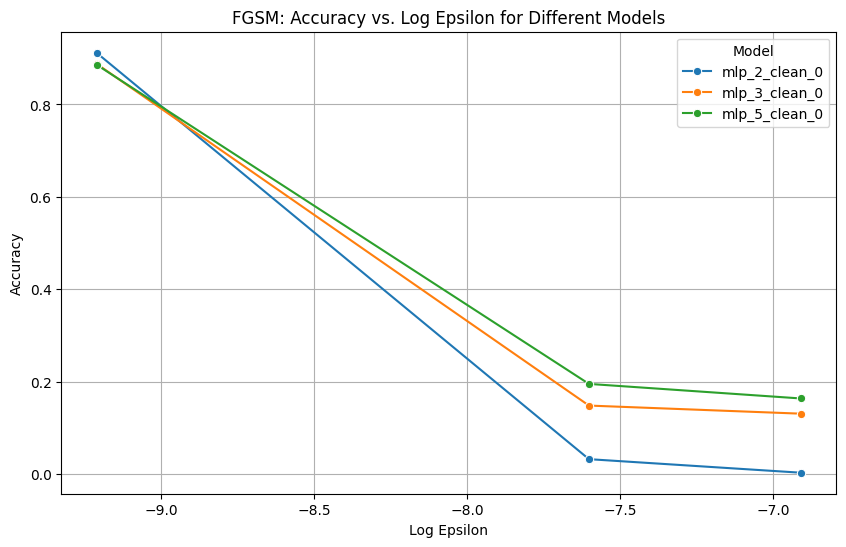

,model,epsilon,accuracy,log_epsilon
0,mlp_2_clean_0,0.0001,0.912007,-9.210340
1,mlp_2_clean_0,0.0005,0.032621,-7.600902
2,mlp_2_clean_0,0.0010,0.003289,-6.907755
3,mlp_3_clean_0,0.0001,0.888158,-9.210340
4,mlp_3_clean_0,0.0005,0.148575,-7.600902
5,mlp_3_clean_0,0.0010,0.131031,-6.907755
6,mlp_5_clean_0,0.0001,0.886239,-9.210340
7,mlp_5_clean_0,0.0005,0.195450,-7.600902
8,mlp_5_clean_0,0.0010,0.163925,-6.907755


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]

def experiment_fgsm(models, loader):
    epsilons = [0.0001, 0.0005, 0.001]

    accuracies = []

    for model in models:
        for eps in epsilons:
            accuracy, loss = run_epoch(model, loader, attack=fgsm, eps=eps, description=f"[Valid] Model: {model.name}, Epsilon: {eps:.5f}")
            accuracies.append({'model': model.name, 'epsilon': eps, 'accuracy': accuracy})

    accuracies_df = pd.DataFrame(accuracies)

    accuracies_df['log_epsilon'] = np.log(accuracies_df['epsilon'])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=accuracies_df, x='log_epsilon', y='accuracy', hue='model', marker='o')

    plt.xlabel('Log Epsilon')
    plt.ylabel('Accuracy')
    plt.title('FGSM: Accuracy vs. Log Epsilon for Different Models')
    plt.legend(title='Model')
    plt.grid(True)
    plt.show()

    return accuracies_df

experiment_fgsm(models, valid_loader)

### ALBERT

In [ ]:
def fgsm_albert(model, data, eps=0.1, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids)

    delta = torch.zeros_like(embeddings, requires_grad=True)
    perturbed_embeddings = embeddings + delta

    outputs = model(inputs_embeds=perturbed_embeddings,
                    attention_mask=data['attention_mask'].to(device),
                    labels=labels)

    loss = outputs.loss
    model.zero_grad()
    loss.backward()

    perturbed_delta = eps * delta.grad.detach().sign()
    perturbed_embeddings = embeddings + perturbed_delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return perturbed_delta, perturbed_embeddings, correct_predictions, 1
    return perturbed_delta, perturbed_embeddings, correct_predictions

def run_albert_epoch(model, loader, attack, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    total_correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, data in bar:
            deltas, perturbed_embeddings, correct_predictions = attack(model, data, **kwargs)
            total_correct_predictions += correct_predictions

    accuracy = total_correct_predictions / len(loader.dataset)

    return accuracy

epsilons = [0.001, 0.01, 0.1, 1.0]
accuracies = []
for eps in epsilons:
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=fgsm_albert, opt=None, description='ALBERT', eps=eps)
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

## Projected Gradient Descent

The average absolute value of the gradient for any given feature is around 10^-5 at the initial zero point, necessitating scaling by a relatively large α to make any progress. Once we "break out" of the initial region around δ=0, the gradients typically increase substantially in magnitude. At this point, our large α becomes excessive, causing the method to take too large a step toward the boundary, effectively acting like FGSM.

### PGD Infinity Norm

In [ ]:
def pgd_linf(model, X, y, eps=0.001, alpha=0.0001, num_iter=50, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter
    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 12.12it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 11.95it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 12.07it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 11.69it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 11.61it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 11.73it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 10.83it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 10.74it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 10.67it/s]


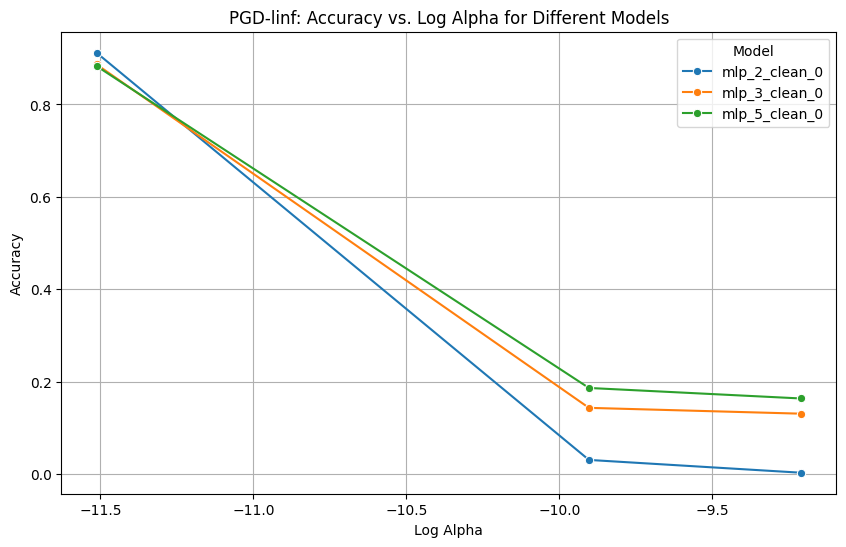

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.00001,0.912007,-11.512925
1,mlp_2_clean_0,0.00005,0.030976,-9.903488
2,mlp_2_clean_0,0.00010,0.003289,-9.210340
3,mlp_3_clean_0,0.00001,0.886787,-11.512925
4,mlp_3_clean_0,0.00005,0.143640,-9.903488
5,mlp_3_clean_0,0.00010,0.131031,-9.210340
6,mlp_5_clean_0,0.00001,0.883224,-11.512925
7,mlp_5_clean_0,0.00005,0.186678,-9.903488
8,mlp_5_clean_0,0.00010,0.163925,-9.210340


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.001]
alphas = [eps / 10.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [ ]:
def pgd_linf_albert(model, data, eps=0.01, alpha=0.001, num_iter=5, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        loss = outputs.loss
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

epsilons = [0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=pgd_linf_albert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

### PGD Infinity Norm with Random Restarts

The performance of PGD is still constrained by the potential presence of local optima within the objective. Although it's impossible to completely eliminate the occurrence of local optima, we can somewhat alleviate this issue through random restarts.

In [ ]:
def pgd_linf_rand(model, X, y, eps=0.001, alpha=0.0001, num_iter=50, restarts=5, return_query_count=False):
    model.eval()
    max_loss = torch.zeros(X.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * eps - eps

        for t in range(num_iter):
            loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
            loss.backward()
            delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
            delta.grad.zero_()

        all_loss = nn.BCELoss(reduction='none')(model(X + delta).squeeze(1), y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    if return_query_count:
        return max_delta, num_iter * restarts + restarts

    return max_delta

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:05<00:00,  2.81it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.83it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.84it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


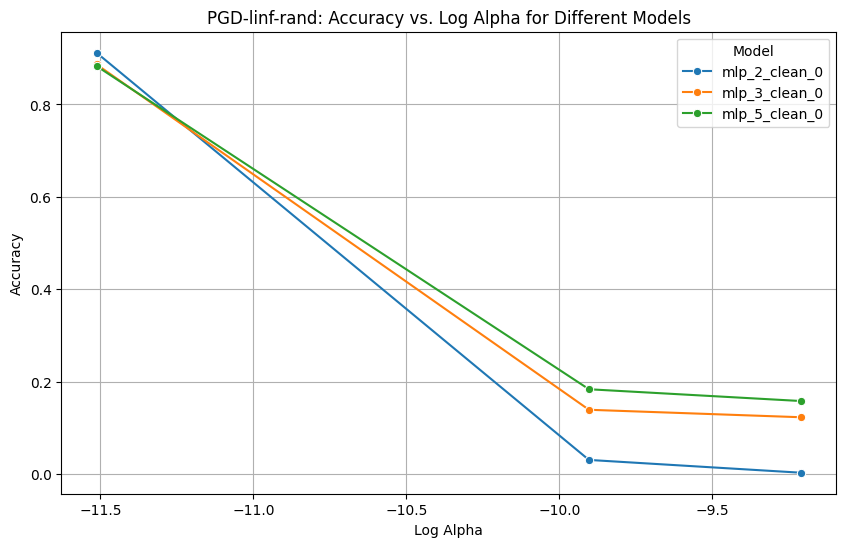

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.00001,0.912007,-11.512925
1,mlp_2_clean_0,0.00005,0.030702,-9.903488
2,mlp_2_clean_0,0.00010,0.003015,-9.210340
3,mlp_3_clean_0,0.00001,0.886787,-11.512925
4,mlp_3_clean_0,0.00005,0.139254,-9.903488
5,mlp_3_clean_0,0.00010,0.123081,-9.210340
6,mlp_5_clean_0,0.00001,0.883224,-11.512925
7,mlp_5_clean_0,0.00005,0.183662,-9.903488
8,mlp_5_clean_0,0.00010,0.158169,-9.210340


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.001]
alphas = [eps / 10.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_rand, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-rand: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

### PGD L2 Norm

In [ ]:
def norms(Z):
    return Z.norm(dim=1)[:, None] + 1e-10


def pgd_l2(model, X, y, eps=0.075, alpha=0.00375, num_iter=50, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
        loss.backward()
        delta.data += alpha * delta.grad.detach() / norms(delta.grad.detach())
        delta.data *= eps / norms(delta.detach()).clamp(min=eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter

    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:01<00:00, 11.40it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0750, Alpha: 0.0037: 100%|██████████| 15/15 [00:01<00:00, 11.40it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:01<00:00, 11.62it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0750, Alpha: 0.0037: 100%|██████████| 15/15 [00:01<00:00, 11.01it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:01<00:00, 11.09it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0750, Alpha: 0.0037: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


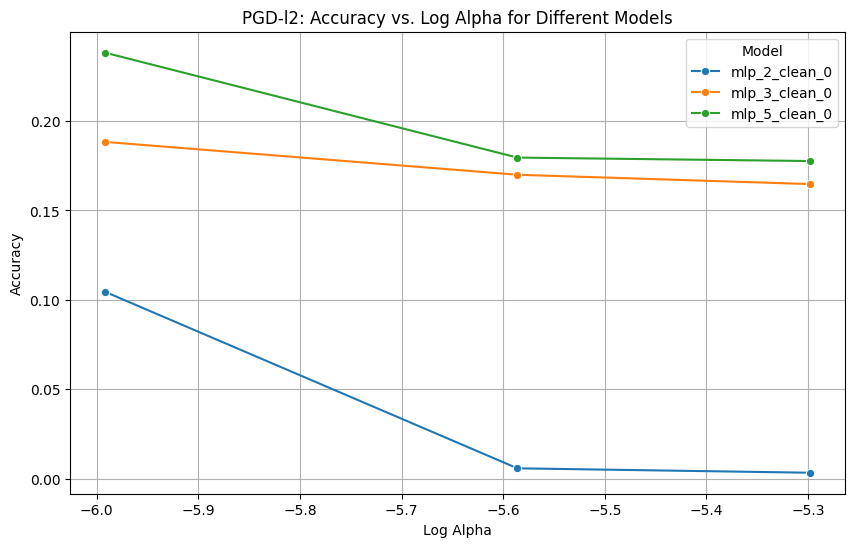

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.00250,0.104441,-5.991465
1,mlp_2_clean_0,0.00375,0.005757,-5.585999
2,mlp_2_clean_0,0.00500,0.003289,-5.298317
3,mlp_3_clean_0,0.00250,0.188322,-5.991465
4,mlp_3_clean_0,0.00375,0.169956,-5.585999
5,mlp_3_clean_0,0.00500,0.164748,-5.298317
6,mlp_5_clean_0,0.00250,0.238213,-5.991465
7,mlp_5_clean_0,0.00375,0.179550,-5.585999
8,mlp_5_clean_0,0.00500,0.177632,-5.298317


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.05, 0.075, 0.1]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_l2, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-l2: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [ ]:
def norms(Z):
    return Z.norm(dim=1)[:, None] + 1e-10

def pgd_l2_albert(model, data, eps=0.1, alpha=0.01, num_iter=5, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        loss = outputs.loss
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach() / norms(delta.grad.detach())
            delta *= eps / norms(delta.detach()).clamp(min=eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

def run_albert_epoch(model, loader, attack, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    total_correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, data in bar:
            deltas, perturbed_embeddings, correct_predictions = attack(model, data, **kwargs)
            total_correct_predictions += correct_predictions

    accuracy = total_correct_predictions / len(loader.dataset)

    return accuracy

epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=pgd_l2_albert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

### PGD L2 Norm with Random Restarts

In [ ]:
def pgd_l2_rand(model, X, y, eps=0.075, alpha=0.00375, num_iter=50, restarts=5, return_query_count=False):
    model.eval()
    max_loss = torch.zeros(X.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * eps - eps

        for t in range(num_iter):
            loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
            loss.backward()
            delta.data += alpha * delta.grad.detach() / norms(delta.grad.detach())
            delta.data *= eps / norms(delta.detach()).clamp(min=eps)
            delta.grad.zero_()

        all_loss = nn.BCELoss(reduction='none')(model(X + delta).squeeze(1), y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    if return_query_count:
        return max_delta, num_iter * restarts + restarts

    return max_delta

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0750, Alpha: 0.0037: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0750, Alpha: 0.0037: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0750, Alpha: 0.0037: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


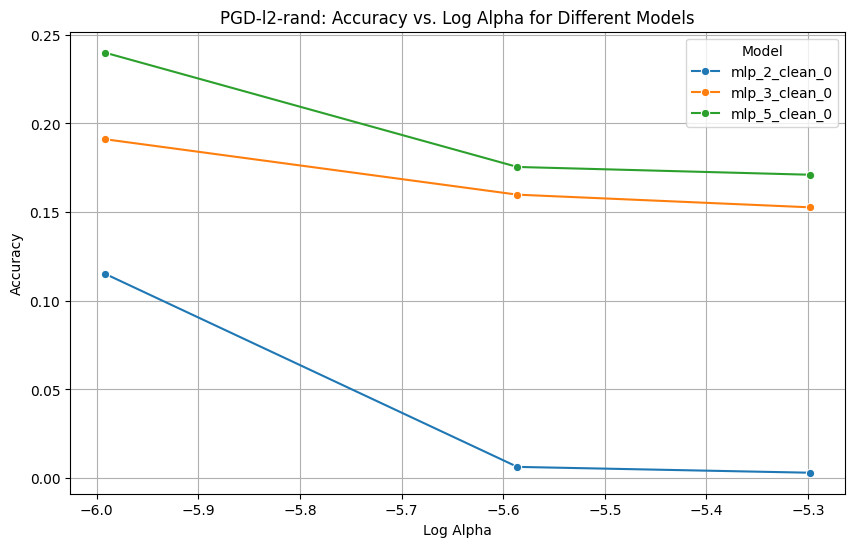

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.00250,0.115132,-5.991465
1,mlp_2_clean_0,0.00375,0.006305,-5.585999
2,mlp_2_clean_0,0.00500,0.003015,-5.298317
3,mlp_3_clean_0,0.00250,0.191064,-5.991465
4,mlp_3_clean_0,0.00375,0.159814,-5.585999
5,mlp_3_clean_0,0.00500,0.152686,-5.298317
6,mlp_5_clean_0,0.00250,0.239857,-5.991465
7,mlp_5_clean_0,0.00375,0.175439,-5.585999
8,mlp_5_clean_0,0.00500,0.171053,-5.298317


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.05, 0.075, 0.1]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_l2_rand, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-l2-rand: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

## Targeted Attacks
In targeted attacks, we maximize the loss associated with the true label while also minimizing the loss for the alternative label.

In [ ]:
def pgd_linf_targ(model, X, y, eps=0.00075, alpha=0.000075, num_iter=50, y_targ=0, return_query_count=False):
    model.eval()

    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        yp = torch.concat([1 - yp, yp], axis=1)
        loss = (yp[:, y_targ].unsqueeze(1) - yp.gather(1, y.long()[:, None])).sum()
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter

    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 11.53it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 12.00it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0008, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 11.97it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 11.95it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 11.15it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0008, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 11.37it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 11.45it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]
[Valid] Mo

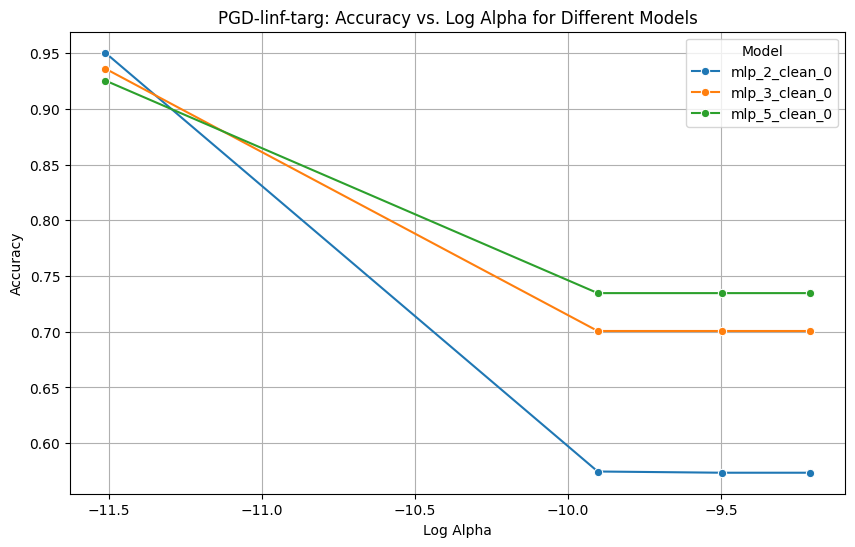

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.000010,0.950384,-11.512925
1,mlp_2_clean_0,0.000050,0.574561,-9.903488
2,mlp_2_clean_0,0.000075,0.573465,-9.498022
3,mlp_2_clean_0,0.000100,0.573465,-9.210340
4,mlp_3_clean_0,0.000010,0.936129,-11.512925
5,mlp_3_clean_0,0.000050,0.700658,-9.903488
6,mlp_3_clean_0,0.000075,0.700658,-9.498022
7,mlp_3_clean_0,0.000100,0.700658,-9.210340
8,mlp_5_clean_0,0.000010,0.925439,-11.512925
9,mlp_5_clean_0,0.000050,0.734649,-9.903488


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.00075, 0.001]
alphas = [eps / 10.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_targ, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-targ: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [ ]:
def pgd_linf_targ_albert(model, data, eps=0.01, alpha=0.001, num_iter=5, y_targ=0, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        logits = outputs.logits
        loss = (logits[:, y_targ] - logits.gather(1, labels[:,None])[:,0]).sum()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

def run_albert_epoch(model, loader, attack, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    total_correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, data in bar:
            deltas, perturbed_embeddings, correct_predictions = attack(model, data, **kwargs)
            total_correct_predictions += correct_predictions

    accuracy = total_correct_predictions / len(loader.dataset)

    return accuracy

epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=pgd_linf_targ_albert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

In [ ]:
def pgd_linf_targ2(model, X, y, eps=0.00075, alpha=0.000075, num_iter=40, y_targ=0, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        yp = torch.concat([1 - yp, yp], axis=1)
        loss = 2 * yp[:, y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter
    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 13.98it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 14.43it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0008, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 14.45it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 14.45it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 13.76it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 13.28it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0008, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 13.25it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:01<00:00, 13.84it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:01<00:00, 11.76it/s]
[Valid] Mo

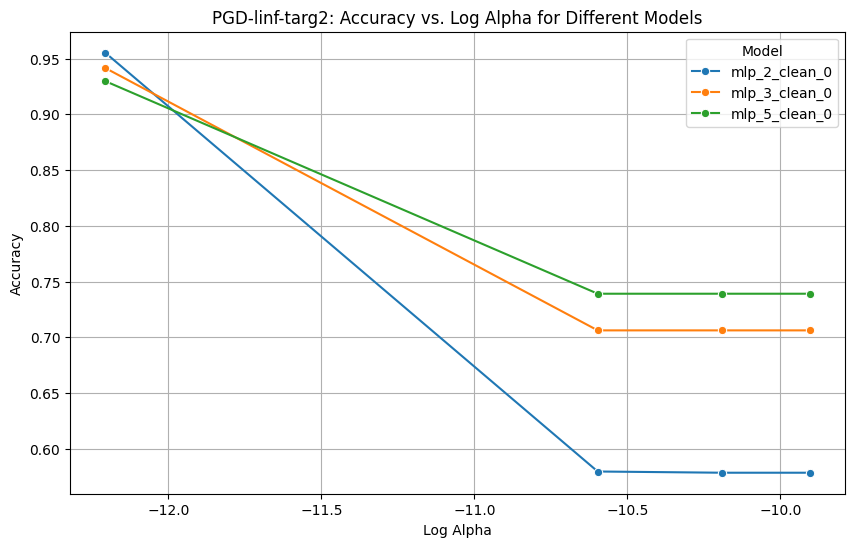

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.000005,0.955318,-12.206073
1,mlp_2_clean_0,0.000025,0.579496,-10.596635
2,mlp_2_clean_0,0.000038,0.578399,-10.191170
3,mlp_2_clean_0,0.000050,0.578399,-9.903488
4,mlp_3_clean_0,0.000005,0.941612,-12.206073
5,mlp_3_clean_0,0.000025,0.706140,-10.596635
6,mlp_3_clean_0,0.000038,0.706140,-10.191170
7,mlp_3_clean_0,0.000050,0.706140,-9.903488
8,mlp_5_clean_0,0.000005,0.929825,-12.206073
9,mlp_5_clean_0,0.000025,0.739035,-10.596635


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.00075, 0.001]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [40]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_targ2, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-targ2: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [ ]:
def pgd_linf_targ2_albert(model, data, eps=0.1, alpha=0.01, num_iter=5, y_targ=0, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        logits = outputs.logits
        loss = 2 * logits[:, y_targ].sum() - logits.sum()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

def run_albert_epoch(model, loader, attack, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    total_correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, data in bar:
            deltas, perturbed_embeddings, correct_predictions = attack(model, data, **kwargs)
            total_correct_predictions += correct_predictions

    accuracy = total_correct_predictions / len(loader.dataset)

    return accuracy

epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=pgd_linf_targ2_albert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

NameError: name 'albert' is not defined

## Ensemble

In [ ]:
def ensemble_attack(model, inputs, labels, child_attacks, return_query_count=False):
    avg_deltas = None
    total_query_count = 0
    for attack in attacks:
        if return_query_count:
            deltas, query_count = attack(model, inputs, labels, return_query_count=True)
            total_query_count += query_count
        else:
            deltas = attack(model, inputs, labels, return_query_count=False)

        if avg_deltas is None:
            avg_deltas = deltas
        else:
            avg_deltas += deltas
    avg_deltas /= len(attacks)

    if return_query_count:
        return avg_deltas, total_query_count
    return avg_deltas

[Valid] Model: mlp_5_clean_0: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


,model,accuracy
0,mlp_2_clean_0,0.034265
1,mlp_3_clean_0,0.191612
2,mlp_5_clean_0,0.254386


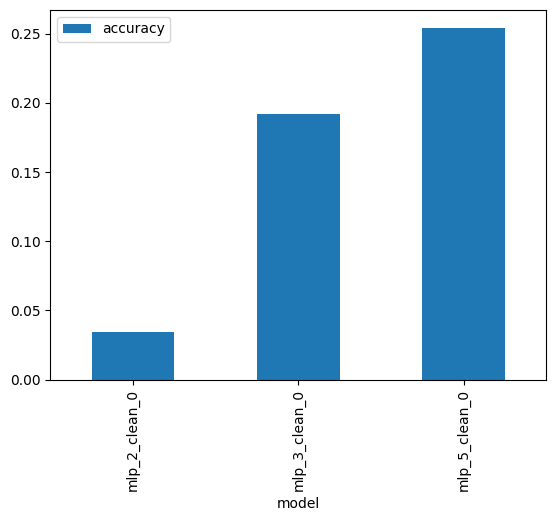

In [ ]:
attacks = [
    pgd_linf_targ2,
    pgd_linf_targ,
    pgd_l2,
    pgd_l2_rand,
    pgd_linf,
    pgd_linf_rand,
    fgsm
]
models = [model_mlp_2, model_mlp_3, model_mlp_5]

accuracies = []

for model in models:
    accuracy, loss = run_epoch(model, valid_loader, attack=ensemble_attack, child_attacks=attacks,
                               description=f"[Valid] Model: {model.name}")

    accuracies.append({'model': model.name, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df.plot(x='model', y='accuracy', kind='bar')

accuracies_df

## Crafting Adversarial Emails in Word Space

In [ ]:
attacks = [
    pgd_linf_targ2,
    # pgd_linf_targ,
    # pgd_l2,
    # pgd_l2_rand,
    # pgd_linf,
    # pgd_linf_rand,
    # fgsm
]

attack_name = 'albert_pgd_linf_targ2'
model = albert
model.eval()

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

### Crafting Adversarial Vocabulary

In [ ]:
y_spam_train = y_train[y_train == 1]
X_spam_train = X_train[y_train == 1]

train_spam_tfidf_df = pd.DataFrame(vectorizer.transform(X_spam_train).toarray(), columns=vectorizer.get_feature_names_out())
train_spam_loader = DataLoader(TFIDFDataset(train_spam_tfidf_df, y_spam_train), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_delta_list = []

def wrap_attack(model, inputs, labels):
    avg_deltas = ensemble_attack(model, inputs, labels, attacks)

    train_delta_list.append(avg_deltas.cpu().detach().numpy())

    return avg_deltas

accuracy, loss = run_epoch(model, train_spam_loader, attack=wrap_attack,
                           description=f"Model: {model.name}")

train_deltas_df = pd.DataFrame(np.vstack(train_delta_list))

assert train_deltas_df.shape[0] == X_spam_train.shape[0]
assert train_deltas_df.shape[1] == train_tfidf_df.shape[1]

Model: mlp_5: 100%|██████████| 49/49 [00:11<00:00,  4.34it/s]


The key high-level element to note here is that while ℓ∞ attacks result in small noise distributed uniformly across the features (precisely because this type of perturbation is allowable under the ℓ∞ ball), ℓ2 attacks lead to perturbations that are more localized within the image. This occurs because we can "trade off" a larger perturbation at one point in the space for a smaller perturbation at another.

ℓ1 attacks, by the nature of the ℓ1 norm, encourage sparsity in the δ perturbation, i.e., they will have only a few features that are adjusted.

TODO:
1. Emperically compare l-inf and l2

In [ ]:
train_deltas_df.columns = train_tfidf_df.columns

In [ ]:
means = train_deltas_df.mean(axis=0)
top = int(train_deltas_df.shape[1] * 0.1)
top_means = means.sort_values(ascending=False).head(top)
to_insert_vocabulary = top_means.index.tolist()

In [ ]:
to_insert_vocabulary[0:5]

['ron', 'vince', 'louise', 'wrote', 'en']

### Computing Token Importance

In [ ]:
def find_indices(A, B):
    index_map = {val: i for i, val in enumerate(B)}
    indices = [index_map.get(a, None) for a in A]
    return [index for index in indices if index is not None]

def compute_token_importance(model, vectorizer, spam_sample):
    tfidf_sample = vectorizer.transform([spam_sample])
    df_sample = pd.DataFrame(tfidf_sample.toarray(), columns=vectorizer.get_feature_names_out())
    tensor_sample = torch.tensor(df_sample.to_numpy()).float().to(device)
    label_sample = torch.tensor([1]).float().to(device)

    indices = find_indices(spam_sample.split(), vectorizer.get_feature_names_out())

    to_replace = []
    avg_deltas = None
    total_query_count = 0
    for attack in attacks:
        delta, query_count = attack(model, tensor_sample, label_sample, return_query_count=True)
        total_query_count += query_count
        if avg_deltas is None:
            avg_deltas = delta.cpu().detach().numpy()
        else:
            avg_deltas += delta.cpu().detach().numpy()
    avg_deltas /= len(attacks)

    to_replace.extend([(vectorizer.get_feature_names_out()[idx], avg_deltas[0, idx]) for idx in indices if avg_deltas[0, idx] < 0])
    to_replace = sorted(to_replace, key=lambda x: x[1])

    return to_replace, total_query_count

### GPT Replacement Attack (Attempt 1)

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key='',
)

def get_completion(prompt, model="gpt-4-0125-preview", temperature=0):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response.choices[0].message.content

In [ ]:
def replace_placeholders(text, replacements):
    for replacement in replacements:
        text = text.replace("<< REPLACE ME >>", replacement.strip(), 1)
    return text

def fix_grammar_errors(email):
    prompt = f"""Fix the grammar errors in the following text:
    {email}
    """

    response = get_completion(prompt)
    return response.strip()

def top_k_candidates(adversarial_sample, to_replace, k=3, model='gpt-4-0125-preview', debug=False):
    replacement_count = adversarial_sample.count("<< REPLACE ME >>")
    candidate_replacements = set([to_replace, to_replace.capitalize()])

    candidates = []
    for i in range(k):
        prompt = f"""
            Step 1: Exactly replace {f"all {replacement_count} instances" if replacement_count > 1 else f"1 instance"} of "<< REPLACE ME >>" in the text enclosed by "!!!" with suitable words or phrases for logical reading flow and grammar correctness.
                Pick words/phrases from the vocabulary enclosed by "???" for replacements. Do NOT use words/phrases {', '.join([f'"{c}"' for c in candidate_replacements])} or stop words to replace "<< REPLACE ME >>".
            Step 2: Return only the replacements{', separate each with "|"' if replacement_count > 1 else ''}. Ensure the count of replacements to exactly be {replacement_count}.

        Masked text:
        !!!{adversarial_sample}!!!

        Vocabulary:
        ???{' '.join(to_insert_vocabulary)}???
        """
        # print(f"Prompt [{i}]:", prompt)
        response = get_completion(prompt, model=model)
        # print('GPT response:', response)

        replacements = response.strip().split('|')
        candidate_replacements.update(replacements)
        # print(replacements)

        replaced_text = replace_placeholders(adversarial_sample, replacements)
        candidates.append((replaced_text, replacements))

    # print(candidates)

    return candidates

In [ ]:
def predict(email, model, vectorizer):
    tfidf = vectorizer.transform([' '.join(tokenizer.tokenize(email))])
    df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    return model(torch.tensor(df.to_numpy()).float().to(device))

In [ ]:
def replace_attack(spam_sample, k=1):
    total_query_count = 0
    total_mlm_query_count = 0

    final_replacements = set()
    adversarial_sample = tokenizer.tokenize(spam_sample)

    to_replace, query_count = compute_token_importance(model, vectorizer, ' '.join(adversarial_sample))
    total_query_count += query_count
    for token, importance in to_replace:
        mask_indices = [i for i, word in enumerate(adversarial_sample) if word == token]
        # Mask all occurrences of the current to-replace token
        for mask_index in mask_indices:
            j = mask_index
            adversarial_sample[j] = '<< REPLACE ME >>'
            # Mask all word pieces of the current occurrence: ['sleep', '##ing'] => [MASK]
            for i in range(j + 1, len(adversarial_sample)):
                if adversarial_sample[i].startswith('##'):
                    adversarial_sample[i] = ''
                else:
                    break

            if adversarial_sample[j].startswith('##'):
                for i in range(j - 1, -1, -1):
                    adversarial_sample[i] = ''
                    if adversarial_sample[i].startswith('##') == False:
                        break


        adversarial_sample = [token for token in adversarial_sample if token != '']
        candidates = top_k_candidates(' '.join(adversarial_sample), token, k=k)
        total_mlm_query_count += k
        assert len(candidates) == k

        accuracies = [(candidate[0], predict(candidate[0].replace(' ##', ''), model, vectorizer).item(), candidate[1]) for candidate in candidates]
        total_query_count += 1
        sorted_accuracies = sorted(accuracies, key=lambda x: x[1])
        successful_candidates = [accuracy for accuracy in sorted_accuracies if accuracy[1] < 0.5]
        final_replacements.update(sorted_accuracies[0][2])
        if len(successful_candidates) > 0:
            print('Successful!', predict(successful_candidates[0][0].replace(' ##', ''), model, vectorizer).item())
            return successful_candidates[0][0], final_replacements
        else:
            adversarial_sample = sorted_accuracies[0][0].split(' ')

    print('Failed!    ', predict(' '.join(adversarial_sample).replace(' ##', ''), model, vectorizer).item())
    return ' '.join(adversarial_sample), final_replacements, total_query_count, total_mlm_query_count

In [ ]:
val_spam_df = X_val[y_val == 1].copy()
val_spam_df.reset_index(drop=True, inplace=True)
val_spam_df.shape

(1550,)

In [ ]:
raw_df = pd.read_csv(os.path.join(data_path, 'preprocessed/raw_all.csv'))

def get_original_spam(spam):
    return raw_df[raw_df['text'] == spam]['original_text'].iloc[0]

In [ ]:
spam_samples = val_spam_df.sample(25)
spam_samples.to_csv(os.path.join(output_path, 'spam_samples.csv'), index=False)
for spam in spam_samples:
    print(spam)
    print()

buy prescription medication from the comfort of your home ! your reliable source for prescription drugs without prescription a fault confessed is half red ##ressed . a certain amount of danger is essential to the quality of life . we can lick gravity , but sometimes the paperwork is overwhelming .

30 seconds application hello , we sent you an email a while ago , because you now qualify for a much lower rate based on the biggest rate drop in years . you can now get $ 300 , 000 for as little as $ 650 a month ! bad credit ? doesn ' t matter , low rates are fixed no matter what ! follow this link to process your application and a 24 hour approval : best regards , hope with ##ers ##poo ##n to be re ##mo ##v ( ed : http : / / www . dropped ##r 8 z . com / x / st . html

special promotion - get a $ 250 gift card a fly and a flea in a flu ##e a fly and a flea in a flu ##e were imprisoned , so what could they do ? said the fly , " let us flee ! " " let us fly ! " said the flea , and they flew 

In [ ]:
spam_samples = pd.read_csv(os.path.join(output_path, 'spam_samples.csv'))['text'].tolist()

results = []
for spam_sample in spam_samples:
    adversarial_sample, final_replacements, query_count, mlm_query_count = replace_attack(fix_grammar_errors(spam_sample))
    results.append((get_original_spam(spam_sample), spam_sample, adversarial_sample, final_replacements, query_count, mlm_query_count))

Successful! 0.06484543532133102
Failed! 0.9968191385269165
Successful! 0.0011184531031176448
Successful! 0.07755810767412186
Failed! 0.9332521557807922
Successful! 0.21789111196994781
Successful! 0.3575693964958191
Successful! 0.22540229558944702
Failed! 0.9990678429603577
Successful! 0.09016512334346771
Successful! 0.48193666338920593
Successful! 0.3422832489013672
Failed! 0.1713535338640213
Successful! 0.4441002607345581
Successful! 0.0016708432231098413
Failed! 0.9443255066871643
Failed! 1.0
Successful! 0.016207927837967873
Successful! 0.00496546970680356
Successful! 0.07070916891098022
Successful! 0.41543400287628174
Successful! 0.45065152645111084
Successful! 0.0326937772333622
Successful! 0.007547373417764902
Failed! 0.6896035671234131


In [ ]:
preds = []
for result in results:
    original_sample = result[0]
    spam_sample = result[1]
    adversarial_sample = result[2]

    # print('***' * 10)
    # print(f"Original sample: {original_sample}")

    # print(f"Spam sample: {spam_sample}")
    # print(predict(spam_sample, model, vectorizer).item())

    # print(f"Adversarial sample: {adversarial_sample}")
    # print(predict(adversarial_sample, model, vectorizer).item())

    result = result + (predict(spam_sample, model, vectorizer).item(),)
    result = result + (predict(adversarial_sample.replace(' ##', ''), model, vectorizer).item(),)
    preds.append(result)

In [ ]:
preds_df = pd.DataFrame(preds, columns=['original_sample', 'spam_sample', 'adversarial_sample', 'final_replacements', 'spam_sample_pred', 'adversarial_sample_pred', 'target_model_query_count', 'mlm_query_count'])
preds_df.to_csv(os.path.join(output_path, f'{attack_name}_gpt.csv'), index=False)

In [ ]:
preds_df

,original_sample,spam_sample,adversarial_sample,final_replacements,spam_sample_pred,adversarial_sample_pred
0,buy prescription medication from the comfort o...,buy prescription medication from the comfort o...,buy online medicinal from the comfort of your ...,"{drugs, your, reliable, medicinal, discussing,...",0.999994,0.064845
1,"30 seconds application hello ,\nwe sent you an...","30 seconds application hello , we sent you an ...","30 - second message : hello , our sent your lo...","{request, matter, notification, borrow, might,...",0.999999,0.996819
2,special promotion - get a $ 250 gift card a fl...,special promotion - get a $ 250 gift card a fl...,special promotion - get a $ 250 gift card a da...,"{flea, flee, dare}",0.999293,0.001118
3,"liffe is great hello ,\nvlsit our medsbymail s...","li ##ffe is great hello , v ##ls ##it our med ...","life is great ! hello , discuss our med ##s - ...","{to, magnesium, our, programme, discuss, be, u...",1.000000,0.077558
4,= ? utf - 8 ? q ? real replica watches ? = = ?...,= ? ut ##f - 8 ? q ? real replica watches ? = ...,certainly ! here ' s a corrected version of th...,"{genuine, watches, Rolex, ron, vince}",0.999990,0.933252
5,you won our xmas bonanza lottery eagel lotto b...,you won our x ##mas bon ##anza lottery ea ##ge...,"ron vince vince x ##mas bon ##anza lottery , e...","{louise, mention, ticket, part, award, quickly...",0.999988,0.217891
6,would you believe it ? i think you ' re meant ...,would you believe it ? i think you ' re meant ...,would would believe it ? i think anyone ' re m...,"{logical, clear, walk, they, succeed, would, y...",0.994715,0.357569
7,"\ / 1 coddin , codeilne ; vlaagrra . xanaa , c...","/ 1 cod ##din , code ##il ##ne ; v ##la ##ag #...",the provided text appears to be a linguistic o...,"{wrote, sought, purpose, global, mistakes, he...",1.000000,0.225402
8,"online software , download ms 2003 , adobe , w...","online software , download ms 2003 , adobe , w...","online utilities , utilities ms office , adobe...","{using, interface, to, disasters, encryption, ...",1.000000,0.999068
9,better health and prosperity since 1924 our of...,better health and prosperity since 1924 our of...,better linguistics linguistics linguistics sin...,"{linguistics, supplied, remain, erectile, slee...",0.999995,0.090165


### GPT Replacement Attack (Attempt 2)


In [ ]:
import copy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

attacks = [
    pgd_linf_targ2_albert,
]

attack_name = 'albert_pgd_linf_targ2'
model = albert
model.eval()


filter_words = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost',
                'alone', 'along', 'already', 'also', 'although', 'am', 'among', 'amongst', 'an', 'and', 'another',
                'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as',
                'at', 'back', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides',
                'between', 'beyond', 'both', 'but', 'by', 'can', 'cannot', 'could', 'couldn', "couldn't", 'd', 'didn',
                "didn't", 'doesn', "doesn't", 'don', "don't", 'down', 'due', 'during', 'either', 'else', 'elsewhere',
                'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'first', 'for',
                'former', 'formerly', 'from', 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'he', 'hence',
                'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his',
                'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'isn', "isn't", 'it', "it's",
                'its', 'itself', 'just', 'latter', 'latterly', 'least', 'll', 'may', 'me', 'meanwhile', 'mightn',
                "mightn't", 'mine', 'more', 'moreover', 'most', 'mostly', 'must', 'mustn', "mustn't", 'my', 'myself',
                'namely', 'needn', "needn't", 'neither', 'never', 'nevertheless', 'next', 'no', 'nobody', 'none',
                'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'o', 'of', 'off', 'on', 'once', 'one', 'only',
                'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'per',
                'please', 's', 'same', 'shan', "shan't", 'she', "she's", "should've", 'shouldn', "shouldn't", 'somehow',
                'something', 'sometime', 'somewhere', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs',
                'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein',
                'thereupon', 'these', 'they', 'this', 'those', 'through', 'throughout', 'thru', 'thus', 'to', 'too',
                'toward', 'towards', 'under', 'unless', 'until', 'up', 'upon', 'used', 've', 'was', 'wasn', "wasn't",
                'we', 'were', 'weren', "weren't", 'what', 'whatever', 'when', 'whence', 'whenever', 'where',
                'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while',
                'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'with', 'within', 'without', 'won',
                "won't", 'would', 'wouldn', "wouldn't", 'y', 'yet', 'you', "you'd", "you'll", "you're", "you've",
                'your', 'yours', 'yourself', 'yourselves']
filter_words = set(filter_words)

def find_indices(A, B):
    index_map = {val: i for i, val in enumerate(B)}
    indices = [index_map.get(a, None) for a in A]
    return [(i, index) for i, index in enumerate(indices) if index is not None]

def compute_token_importance(model, spam_sample):
    data = tokenize_function({'text': spam_sample})
    print(data)
    # return pgd_linf_targ2_albert(model, data)


print(compute_token_importance(model, 'healthy all american cooking all year round retail price $ 27 . 95 now only $ 4 . 95 ! healthy all american cooking all year round ! now you can have the great taste'))

NameError: name 'albert' is not defined

In [ ]:
def top_k_candidates_2(spam_sample, important_words, k=3, model='gpt-4-0125-preview', attempt=0):
    prompt = f'''
        For each word in the word list, find the top {k} synonyms (words or phrases) that meet these three conditions:
        - Replacing occurrences of the word in the text with them does not alter the meaning and grammar of the text.
        - Sort the top {k} synonyms by decreasing relevance score within the text's context. The higher the score, the more relevant a replacement word is to the text.

        Format as "word: replacement words" in a single line. Wrap all lines in between a single pair "<<<" and ">>>".

        Text:
        {spam_sample}

        Word list:
        {important_words}
    '''

    response = get_completion(prompt).strip()
    m = re.search(r'<<<(.*?)>>>', response, re.DOTALL)
    # Extract the first pair of text if found
    extracted_text = m.group(1).strip() if m else "No text found"
    if extracted_text == 'No text found':
        print(response)
        attempt += 1
        if attempt < 3:
            return top_k_candidates_2(spam_sample, important_words, k=k, model=model, attempt=attempt)
        else:
            return {}, response

    lines = extracted_text.splitlines()
    substitutes = {}
    for line in lines:
        if line.strip() == '':
            continue

        if len(line.split(':')) < 2:
            print(line)
            continue

        word = line.split(':')[0].strip()
        replacements = line.split(':')[1].strip().split(',')
        replacements = [r.strip() for r in replacements]

        substitutes[word] = replacements

    return substitutes, response

def replace_attack(model, spam_sample, k=2, important_word_size=2):
    change_count = 0
    total_query_count = 0
    replacements = []
    random_attack = False

    tokens = spam_sample.split(' ')
    spam_sample = ' '.join(tokens)
    important_words, query_count = compute_token_importance(model, vectorizer, spam_sample)
    total_query_count += query_count

    if len(important_words) == 0:
        print('Random attack!')
        random_attack = True
        indices = np.random.permutation(len(tokens))[:important_word_size]
        important_words = [(tokens[index], 0.0, index) for index in indices]

    important_words = important_words[:important_word_size]
    print(model)

    processed_important_words = []
    for important_word, important_score, pos in important_words:
        important_word = tokens[pos].strip()

        if '##' in important_word:
            important_word = important_word[2:]
            for i in range(pos - 1, -1, -1):
                if '##' in tokens[i]:
                    important_word = tokens[i][2:] + important_word
                    tokens[i] = ''
                else:
                    important_word = tokens[i] + important_word
                    tokens[i] = ''
                    break


        for i in range(pos + 1, len(tokens)):
            if '##' in tokens[i]:
                important_word += tokens[i][2:]
                tokens[i] = ''
            else:
                break

        tokens[pos] = important_word
        processed_important_words.append((important_word, pos))

    spam_sample = ' '.join(tokens)
    adversarial_tokens = []
    processed_important_words = [(target_word, pos) for target_word, pos in processed_important_words if re.compile(r"^[A-Za-z][\w'-]*$").match(target_word)]

    word_predictions, gpt_response = top_k_candidates_2(spam_sample, [w for w, _ in processed_important_words], k=k)

    original_prob = predict(spam_sample, model, vectorizer).item()

    best_prob = 1.0
    for target_word, pos in processed_important_words:
        if target_word in ENGLISH_STOP_WORDS:
            continue

        if target_word in filter_words:
            continue

        substitutes = word_predictions.get(target_word, [])
        if len(substitutes) == 0:
            continue

        candidate = None
        for substitute in substitutes:
            if substitute == target_word:
                continue

            if substitute in ENGLISH_STOP_WORDS:
                continue

            if substitute in filter_words:
                continue

            adversarial_tokens = tokens[:pos] + [substitute] + tokens[pos + 1:]
            adversarial_sample = ' '.join(adversarial_tokens)
            prob = predict(adversarial_sample, model, vectorizer).item()
            total_query_count += 1

            if prob < 0.5:
                change_count += 1
                replacements.append((pos, target_word, substitute))
                tokens[pos] = substitute

                return adversarial_tokens, change_count, total_query_count, replacements, original_prob, prob, random_attack, gpt_response
            else:
                if prob < best_prob:
                    best_prob = prob
                    candidate = substitute

        if candidate:
            change_count += 1
            replacements.append((pos, target_word, candidate))
            adversarial_tokens = tokens[:pos] + [candidate] + tokens[pos + 1:]
            tokens[pos] = candidate


    return adversarial_tokens, change_count, total_query_count, replacements, original_prob, best_prob, random_attack, gpt_response

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 5.3 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

class USEPyTorch:
    def __init__(self, model_name):
        # Initialize the model from the sentence-transformers library
        self.model = SentenceTransformer(model_name)

    def semantic_sim(self, sents1, sents2):
        # Convert sentences to lower case and get embeddings
        embeddings1 = self.model.encode([s.lower() for s in sents1], convert_to_tensor=True)
        embeddings2 = self.model.encode([s.lower() for s in sents2], convert_to_tensor=True)

        # Compute cosine similarities
        cosine_similarities = util.pytorch_cos_sim(embeddings1, embeddings2)
        return cosine_similarities

model_name = 'all-MiniLM-L6-v2'  # A compact model from sentence-transformers
use_model_pytorch = USEPyTorch(model_name)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# k=2: 39 128 0.4952988922595978
# k=3: 35 154 0.47615158557891846
# Filter stop words for both target and substitute words: 30 139 0.4875030219554901
# Filter more common words: 29 137 0.4993932545185089

# 26 214 0.4596477746963501
# 31 190 0.2735882103443146

spam_samples = val_spam_df.head(1)
results = []
for spam_sample in spam_samples:
    adversarial_tokens, change_count, total_query_count, replacements, original_prob, prob, random_attack, gpt_response = replace_attack(model, spam_sample, k=2, important_word_size=200)
    original_sample = get_original_spam(spam_sample)
    adversarial_sample = ' '.join(adversarial_tokens)
    sim_score = use_model_pytorch.semantic_sim([original_sample], [adversarial_sample]).item()
    results.append({
        'original_sample': original_sample,
        'spam_sample': spam_sample,
        'adversarial_sample': adversarial_sample,
        'original_prob': original_prob,
        'attacked_prob': prob,
        'change_count': change_count,
        'query_count': total_query_count,
        'replacements': replacements,
        'random_attack': random_attack,
        'gpt_response': gpt_response,
        'sim_score': sim_score,
    })
    print(spam_sample)
    print(' '.join(adversarial_tokens))
    print(change_count, total_query_count, prob)
    print('***' * 10)

results = pd.DataFrame(results)
results.to_csv(os.path.join(output_path, f'{attack_name}_gpt_one_pass.csv'), index=False)

MLP(
  (blocks): ModuleList(
    (0): MLPBlock(
      (linear): Linear(in_features=24926, out_features=200, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): MLPBlock(
      (linear): Linear(in_features=200, out_features=100, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (2): MLPBlock(
      (linear): Linear(in_features=100, out_features=50, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (3): MLPBlock(
      (linear): Linear(in_features=50, out_features=25, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (output): Linear(in_features=25, out_features=1, bias=True)
)
healthy all american cooking all year round retail price $ 27 . 95 now only $ 4 . 95 ! healthy all american cooking all year round ! now you can have the great taste , texture and flavor of grille ##d food right in your home , anytime year ' round without awkward equipment . the mighty pro grill turns any electric or gas stove into a gril

# Adversarial Learning

## Adversarial Continuous Data

### FGSM

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_fgsm_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=fgsm)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_fgsm_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 55.32it/s]



Epoch 1/5, Training Accuracy: 0.5770, Training Loss: 0.6623, Validation Accuracy: 0.9490, Validation Loss: 0.3154, Adversarial Accuracy: 0.7738, Adversarial Loss: 0.4808
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.7738). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.19it/s]



Epoch 2/5, Training Accuracy: 0.8228, Training Loss: 0.4012, Validation Accuracy: 0.9704, Validation Loss: 0.0945, Adversarial Accuracy: 0.8761, Adversarial Loss: 0.2954
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7738 --> 0.8761). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 51.22it/s]



Epoch 3/5, Training Accuracy: 0.8837, Training Loss: 0.3013, Validation Accuracy: 0.9742, Validation Loss: 0.0793, Adversarial Accuracy: 0.9076, Adversarial Loss: 0.2397
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.8761 --> 0.9076). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 54.83it/s]



Epoch 4/5, Training Accuracy: 0.9068, Training Loss: 0.2543, Validation Accuracy: 0.9726, Validation Loss: 0.0717, Adversarial Accuracy: 0.9049, Adversarial Loss: 0.2247
Crafted spam accuracy: 0.4211



Adversarial: 100%|██████████| 29/29 [00:00<00:00, 50.04it/s]



Epoch 5/5, Training Accuracy: 0.9200, Training Loss: 0.2235, Validation Accuracy: 0.9749, Validation Loss: 0.0670, Adversarial Accuracy: 0.9209, Adversarial Loss: 0.2027
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.9076 --> 0.9209). Saving model ...
Crafted spam accuracy: 0.4737.
Best crafted spam accuracy: 0.9209. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.92it/s]



Epoch 1/5, Training Accuracy: 0.5745, Training Loss: 0.6633, Validation Accuracy: 0.9408, Validation Loss: 0.3733, Adversarial Accuracy: 0.7105, Adversarial Loss: 0.5202
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.0000 --> 0.7105). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 57.69it/s]



Epoch 2/5, Training Accuracy: 0.7958, Training Loss: 0.4256, Validation Accuracy: 0.9656, Validation Loss: 0.1029, Adversarial Accuracy: 0.8721, Adversarial Loss: 0.3027
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.7105 --> 0.8721). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.22it/s]



Epoch 3/5, Training Accuracy: 0.8802, Training Loss: 0.3066, Validation Accuracy: 0.9744, Validation Loss: 0.0796, Adversarial Accuracy: 0.9101, Adversarial Loss: 0.2366
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8721 --> 0.9101). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.44it/s]



Epoch 4/5, Training Accuracy: 0.9131, Training Loss: 0.2372, Validation Accuracy: 0.9749, Validation Loss: 0.0760, Adversarial Accuracy: 0.9326, Adversarial Loss: 0.1904
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.9101 --> 0.9326). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.47it/s]



Epoch 5/5, Training Accuracy: 0.9258, Training Loss: 0.2122, Validation Accuracy: 0.9775, Validation Loss: 0.0698, Adversarial Accuracy: 0.9261, Adversarial Loss: 0.1901
Crafted spam accuracy: 0.7368

Crafted spam accuracy: 0.6842.
Best crafted spam accuracy: 0.9326. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.29it/s]



Epoch 1/5, Training Accuracy: 0.6291, Training Loss: 0.6070, Validation Accuracy: 0.9602, Validation Loss: 0.1950, Adversarial Accuracy: 0.8162, Adversarial Loss: 0.4001
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.8162). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.90it/s]



Epoch 2/5, Training Accuracy: 0.8429, Training Loss: 0.3700, Validation Accuracy: 0.9711, Validation Loss: 0.0854, Adversarial Accuracy: 0.8768, Adversarial Loss: 0.2798
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8162 --> 0.8768). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 48.51it/s]



Epoch 3/5, Training Accuracy: 0.8856, Training Loss: 0.2927, Validation Accuracy: 0.9766, Validation Loss: 0.0740, Adversarial Accuracy: 0.9077, Adversarial Loss: 0.2340
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8768 --> 0.9077). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 45.05it/s]



Epoch 4/5, Training Accuracy: 0.9102, Training Loss: 0.2488, Validation Accuracy: 0.9785, Validation Loss: 0.0626, Adversarial Accuracy: 0.9293, Adversarial Loss: 0.2036
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.9077 --> 0.9293). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.32it/s]



Epoch 5/5, Training Accuracy: 0.9285, Training Loss: 0.2168, Validation Accuracy: 0.9805, Validation Loss: 0.0622, Adversarial Accuracy: 0.9397, Adversarial Loss: 0.1830
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.9293 --> 0.9397). Saving model ...
Crafted spam accuracy: 0.5789.
Best crafted spam accuracy: 0.9397. Saving the best model ...
Accuracies: [0.47368421052631576, 0.6842105263157895, 0.5789473684210527]
Mean accuracy: 0.5789473684210527


### PGD

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 1/5, Training Accuracy: 0.5593, Training Loss: 0.6750, Validation Accuracy: 0.9494, Validation Loss: 0.4244, Adversarial Accuracy: 0.7083, Adversarial Loss: 0.5420
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.7083). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]



Epoch 2/5, Training Accuracy: 0.7999, Training Loss: 0.4389, Validation Accuracy: 0.9648, Validation Loss: 0.1210, Adversarial Accuracy: 0.8605, Adversarial Loss: 0.3122
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.7083 --> 0.8605). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 3/5, Training Accuracy: 0.8625, Training Loss: 0.3251, Validation Accuracy: 0.9719, Validation Loss: 0.0991, Adversarial Accuracy: 0.8803, Adversarial Loss: 0.2615
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8605 --> 0.8803). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 4/5, Training Accuracy: 0.8834, Training Loss: 0.2854, Validation Accuracy: 0.9764, Validation Loss: 0.0849, Adversarial Accuracy: 0.8943, Adversarial Loss: 0.2386
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8803 --> 0.8943). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 5/5, Training Accuracy: 0.8976, Training Loss: 0.2549, Validation Accuracy: 0.9782, Validation Loss: 0.0731, Adversarial Accuracy: 0.8988, Adversarial Loss: 0.2242
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8943 --> 0.8988). Saving model ...
Crafted spam accuracy: 0.6316.
Best crafted spam accuracy: 0.8988. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 1/5, Training Accuracy: 0.5711, Training Loss: 0.6845, Validation Accuracy: 0.5709, Validation Loss: 0.6834, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6836
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 2/5, Training Accuracy: 0.6620, Training Loss: 0.5637, Validation Accuracy: 0.9533, Validation Loss: 0.1842, Adversarial Accuracy: 0.8333, Adversarial Loss: 0.3704
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.5709 --> 0.8333). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 3/5, Training Accuracy: 0.8441, Training Loss: 0.3656, Validation Accuracy: 0.9733, Validation Loss: 0.1051, Adversarial Accuracy: 0.8728, Adversarial Loss: 0.2769
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8333 --> 0.8728). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 4/5, Training Accuracy: 0.8807, Training Loss: 0.2897, Validation Accuracy: 0.9770, Validation Loss: 0.0841, Adversarial Accuracy: 0.8917, Adversarial Loss: 0.2408
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8728 --> 0.8917). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 5/5, Training Accuracy: 0.8985, Training Loss: 0.2565, Validation Accuracy: 0.9789, Validation Loss: 0.0734, Adversarial Accuracy: 0.8983, Adversarial Loss: 0.2210
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8917 --> 0.8983). Saving model ...
Crafted spam accuracy: 0.7368.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 1/5, Training Accuracy: 0.5605, Training Loss: 0.6851, Validation Accuracy: 0.5709, Validation Loss: 0.6129, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6535
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 2/5, Training Accuracy: 0.7494, Training Loss: 0.4896, Validation Accuracy: 0.9666, Validation Loss: 0.1355, Adversarial Accuracy: 0.8473, Adversarial Loss: 0.3338
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.5709 --> 0.8473). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 3/5, Training Accuracy: 0.8545, Training Loss: 0.3452, Validation Accuracy: 0.9696, Validation Loss: 0.1171, Adversarial Accuracy: 0.8803, Adversarial Loss: 0.2788
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8473 --> 0.8803). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 4/5, Training Accuracy: 0.8827, Training Loss: 0.2861, Validation Accuracy: 0.9757, Validation Loss: 0.0832, Adversarial Accuracy: 0.8929, Adversarial Loss: 0.2410
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8803 --> 0.8929). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 5/5, Training Accuracy: 0.8962, Training Loss: 0.2587, Validation Accuracy: 0.9788, Validation Loss: 0.0698, Adversarial Accuracy: 0.8971, Adversarial Loss: 0.2221
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8929 --> 0.8971). Saving model ...
Crafted spam accuracy: 0.7895.
Accuracies: [0.631578947368421, 0.7368421052631579, 0.7894736842105263]
Mean accuracy: 0.7192982456140351


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_rand_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_rand)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_rand_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.5685, Training Loss: 0.6846, Validation Accuracy: 0.5709, Validation Loss: 0.6632, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6728
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 2/5, Training Accuracy: 0.7130, Training Loss: 0.5142, Validation Accuracy: 0.9546, Validation Loss: 0.1923, Adversarial Accuracy: 0.8404, Adversarial Loss: 0.3628
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.5709 --> 0.8404). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 3/5, Training Accuracy: 0.8457, Training Loss: 0.3661, Validation Accuracy: 0.9718, Validation Loss: 0.1138, Adversarial Accuracy: 0.8781, Adversarial Loss: 0.2833
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8404 --> 0.8781). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 4/5, Training Accuracy: 0.8774, Training Loss: 0.2945, Validation Accuracy: 0.9771, Validation Loss: 0.0858, Adversarial Accuracy: 0.8921, Adversarial Loss: 0.2492
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8781 --> 0.8921). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.8942, Training Loss: 0.2639, Validation Accuracy: 0.9779, Validation Loss: 0.0736, Adversarial Accuracy: 0.9019, Adversarial Loss: 0.2271
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8921 --> 0.9019). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9019. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.5745, Training Loss: 0.6578, Validation Accuracy: 0.9508, Validation Loss: 0.3018, Adversarial Accuracy: 0.7840, Adversarial Loss: 0.4644
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.7840). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 2/5, Training Accuracy: 0.8265, Training Loss: 0.3980, Validation Accuracy: 0.9700, Validation Loss: 0.1115, Adversarial Accuracy: 0.8670, Adversarial Loss: 0.2925
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7840 --> 0.8670). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 3/5, Training Accuracy: 0.8730, Training Loss: 0.3123, Validation Accuracy: 0.9727, Validation Loss: 0.0992, Adversarial Accuracy: 0.8869, Adversarial Loss: 0.2560
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8670 --> 0.8869). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 4/5, Training Accuracy: 0.8930, Training Loss: 0.2681, Validation Accuracy: 0.9779, Validation Loss: 0.0775, Adversarial Accuracy: 0.8920, Adversarial Loss: 0.2343
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8869 --> 0.8920). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.9062, Training Loss: 0.2365, Validation Accuracy: 0.9796, Validation Loss: 0.0680, Adversarial Accuracy: 0.9045, Adversarial Loss: 0.2116
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8920 --> 0.9045). Saving model ...
Crafted spam accuracy: 0.7368.
Best crafted spam accuracy: 0.9045. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 1/5, Training Accuracy: 0.5614, Training Loss: 0.6699, Validation Accuracy: 0.9561, Validation Loss: 0.3962, Adversarial Accuracy: 0.7400, Adversarial Loss: 0.5157
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.7400). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8007, Training Loss: 0.4372, Validation Accuracy: 0.9679, Validation Loss: 0.1109, Adversarial Accuracy: 0.8631, Adversarial Loss: 0.3063
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.7400 --> 0.8631). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.8643, Training Loss: 0.3224, Validation Accuracy: 0.9752, Validation Loss: 0.0848, Adversarial Accuracy: 0.8894, Adversarial Loss: 0.2533
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8631 --> 0.8894). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.8875, Training Loss: 0.2787, Validation Accuracy: 0.9772, Validation Loss: 0.0763, Adversarial Accuracy: 0.8992, Adversarial Loss: 0.2287
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8894 --> 0.8992). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.9015, Training Loss: 0.2497, Validation Accuracy: 0.9790, Validation Loss: 0.0658, Adversarial Accuracy: 0.9049, Adversarial Loss: 0.2113
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8992 --> 0.9049). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9049. Saving the best model ...
Accuracies: [0.7894736842105263, 0.7368421052631579, 0.7894736842105263]
Mean accuracy: 0.7719298245614036


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 1/5, Training Accuracy: 0.5713, Training Loss: 0.6814, Validation Accuracy: 0.5709, Validation Loss: 0.5709, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6427
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 2/5, Training Accuracy: 0.6877, Training Loss: 0.5525, Validation Accuracy: 0.8672, Validation Loss: 0.2791, Adversarial Accuracy: 0.7526, Adversarial Loss: 0.4601
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.5709 --> 0.7526). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 3/5, Training Accuracy: 0.7604, Training Loss: 0.4584, Validation Accuracy: 0.8866, Validation Loss: 0.2229, Adversarial Accuracy: 0.7833, Adversarial Loss: 0.4137
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.7526 --> 0.7833). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 4/5, Training Accuracy: 0.7936, Training Loss: 0.4105, Validation Accuracy: 0.9103, Validation Loss: 0.1756, Adversarial Accuracy: 0.7966, Adversarial Loss: 0.3870
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7833 --> 0.7966). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 5/5, Training Accuracy: 0.8116, Training Loss: 0.3771, Validation Accuracy: 0.9204, Validation Loss: 0.1590, Adversarial Accuracy: 0.8026, Adversarial Loss: 0.3766
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7966 --> 0.8026). Saving model ...
Crafted spam accuracy: 0.6842.
Best crafted spam accuracy: 0.8026. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 1/5, Training Accuracy: 0.5732, Training Loss: 0.6826, Validation Accuracy: 0.5709, Validation Loss: 0.6558, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6713
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 2/5, Training Accuracy: 0.6194, Training Loss: 0.5991, Validation Accuracy: 0.8332, Validation Loss: 0.3267, Adversarial Accuracy: 0.7209, Adversarial Loss: 0.4923
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.5709 --> 0.7209). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]



Epoch 3/5, Training Accuracy: 0.7356, Training Loss: 0.4872, Validation Accuracy: 0.8668, Validation Loss: 0.2491, Adversarial Accuracy: 0.7611, Adversarial Loss: 0.4360
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.7209 --> 0.7611). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 4/5, Training Accuracy: 0.7733, Training Loss: 0.4322, Validation Accuracy: 0.8988, Validation Loss: 0.1977, Adversarial Accuracy: 0.7885, Adversarial Loss: 0.3946
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7611 --> 0.7885). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]



Epoch 5/5, Training Accuracy: 0.8022, Training Loss: 0.3850, Validation Accuracy: 0.9132, Validation Loss: 0.1743, Adversarial Accuracy: 0.7977, Adversarial Loss: 0.3804
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7885 --> 0.7977). Saving model ...
Crafted spam accuracy: 0.6316.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 1/5, Training Accuracy: 0.5732, Training Loss: 0.6778, Validation Accuracy: 0.5709, Validation Loss: 0.5863, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6350
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 2/5, Training Accuracy: 0.5731, Training Loss: 0.6265, Validation Accuracy: 0.5709, Validation Loss: 0.4759, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.5919
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]



Epoch 3/5, Training Accuracy: 0.6095, Training Loss: 0.5916, Validation Accuracy: 0.8875, Validation Loss: 0.3626, Adversarial Accuracy: 0.6728, Adversarial Loss: 0.5316
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.5709 --> 0.6728). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 4/5, Training Accuracy: 0.7039, Training Loss: 0.5029, Validation Accuracy: 0.9372, Validation Loss: 0.2386, Adversarial Accuracy: 0.7132, Adversarial Loss: 0.4489
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.6728 --> 0.7132). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 5/5, Training Accuracy: 0.7593, Training Loss: 0.4383, Validation Accuracy: 0.9629, Validation Loss: 0.1736, Adversarial Accuracy: 0.7450, Adversarial Loss: 0.4038
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.7132 --> 0.7450). Saving model ...
Crafted spam accuracy: 0.7368.
Accuracies: [0.6842105263157895, 0.631578947368421, 0.7368421052631579]
Mean accuracy: 0.6842105263157895


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_rand_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2_rand)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_rand_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 1/5, Training Accuracy: 0.5732, Training Loss: 0.6804, Validation Accuracy: 0.5709, Validation Loss: 0.5926, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6418
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 2/5, Training Accuracy: 0.6681, Training Loss: 0.5575, Validation Accuracy: 0.8677, Validation Loss: 0.2557, Adversarial Accuracy: 0.7552, Adversarial Loss: 0.4464
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.5709 --> 0.7552). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 3/5, Training Accuracy: 0.7660, Training Loss: 0.4494, Validation Accuracy: 0.8981, Validation Loss: 0.2030, Adversarial Accuracy: 0.7829, Adversarial Loss: 0.4015
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7552 --> 0.7829). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 4/5, Training Accuracy: 0.7988, Training Loss: 0.3946, Validation Accuracy: 0.9102, Validation Loss: 0.1627, Adversarial Accuracy: 0.7967, Adversarial Loss: 0.3777
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7829 --> 0.7967). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 5/5, Training Accuracy: 0.8171, Training Loss: 0.3616, Validation Accuracy: 0.9361, Validation Loss: 0.1276, Adversarial Accuracy: 0.8075, Adversarial Loss: 0.3681
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7967 --> 0.8075). Saving model ...
Crafted spam accuracy: 0.6842.
Best crafted spam accuracy: 0.8075. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.5678, Training Loss: 0.6682, Validation Accuracy: 0.7208, Validation Loss: 0.5295, Adversarial Accuracy: 0.6199, Adversarial Loss: 0.6113
Crafted spam accuracy: 0.2105

Adversarial accuracy increased (0.0000 --> 0.6199). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 2/5, Training Accuracy: 0.6452, Training Loss: 0.5744, Validation Accuracy: 0.8499, Validation Loss: 0.2734, Adversarial Accuracy: 0.7212, Adversarial Loss: 0.4804
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.6199 --> 0.7212). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.7512, Training Loss: 0.4674, Validation Accuracy: 0.9298, Validation Loss: 0.1967, Adversarial Accuracy: 0.7764, Adversarial Loss: 0.4172
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7212 --> 0.7764). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 4/5, Training Accuracy: 0.7933, Training Loss: 0.4087, Validation Accuracy: 0.9457, Validation Loss: 0.1426, Adversarial Accuracy: 0.7964, Adversarial Loss: 0.3827
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7764 --> 0.7964). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.8173, Training Loss: 0.3730, Validation Accuracy: 0.9485, Validation Loss: 0.1240, Adversarial Accuracy: 0.8064, Adversarial Loss: 0.3640
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7964 --> 0.8064). Saving model ...
Crafted spam accuracy: 0.6842.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.5651, Training Loss: 0.6747, Validation Accuracy: 0.9103, Validation Loss: 0.4494, Adversarial Accuracy: 0.6566, Adversarial Loss: 0.5910
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.0000 --> 0.6566). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 2/5, Training Accuracy: 0.7119, Training Loss: 0.5181, Validation Accuracy: 0.9025, Validation Loss: 0.2188, Adversarial Accuracy: 0.7668, Adversarial Loss: 0.4280
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.6566 --> 0.7668). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.7791, Training Loss: 0.4297, Validation Accuracy: 0.9258, Validation Loss: 0.1630, Adversarial Accuracy: 0.7945, Adversarial Loss: 0.3856
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7668 --> 0.7945). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 4/5, Training Accuracy: 0.8090, Training Loss: 0.3843, Validation Accuracy: 0.9467, Validation Loss: 0.1323, Adversarial Accuracy: 0.8026, Adversarial Loss: 0.3644
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7945 --> 0.8026). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.8300, Training Loss: 0.3460, Validation Accuracy: 0.9633, Validation Loss: 0.1101, Adversarial Accuracy: 0.8062, Adversarial Loss: 0.3531
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8026 --> 0.8062). Saving model ...
Crafted spam accuracy: 0.7895.
Accuracies: [0.6842105263157895, 0.6842105263157895, 0.7894736842105263]
Mean accuracy: 0.7192982456140351


### Targeted Attacks

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_targ_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_targ)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 1/5, Training Accuracy: 0.7922, Training Loss: 0.3880, Validation Accuracy: 0.9616, Validation Loss: 0.0927, Adversarial Accuracy: 0.9323, Adversarial Loss: 0.1672
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.0000 --> 0.9323). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 2/5, Training Accuracy: 0.9391, Training Loss: 0.1744, Validation Accuracy: 0.9753, Validation Loss: 0.0656, Adversarial Accuracy: 0.9365, Adversarial Loss: 0.1542
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.9323 --> 0.9365). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]



Epoch 3/5, Training Accuracy: 0.9543, Training Loss: 0.1303, Validation Accuracy: 0.9766, Validation Loss: 0.0575, Adversarial Accuracy: 0.9423, Adversarial Loss: 0.1451
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9365 --> 0.9423). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 4/5, Training Accuracy: 0.9658, Training Loss: 0.0994, Validation Accuracy: 0.9687, Validation Loss: 0.0649, Adversarial Accuracy: 0.9460, Adversarial Loss: 0.1410
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9423 --> 0.9460). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.81it/s]



Epoch 5/5, Training Accuracy: 0.9753, Training Loss: 0.0725, Validation Accuracy: 0.9746, Validation Loss: 0.0717, Adversarial Accuracy: 0.9467, Adversarial Loss: 0.1793
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9460 --> 0.9467). Saving model ...
Crafted spam accuracy: 0.8947.
Best crafted spam accuracy: 0.9467. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.68it/s]



Epoch 1/5, Training Accuracy: 0.7604, Training Loss: 0.4215, Validation Accuracy: 0.9629, Validation Loss: 0.0905, Adversarial Accuracy: 0.9301, Adversarial Loss: 0.1736
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.0000 --> 0.9301). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 2/5, Training Accuracy: 0.9368, Training Loss: 0.1802, Validation Accuracy: 0.9681, Validation Loss: 0.0719, Adversarial Accuracy: 0.9441, Adversarial Loss: 0.1448
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9301 --> 0.9441). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 3/5, Training Accuracy: 0.9516, Training Loss: 0.1395, Validation Accuracy: 0.9650, Validation Loss: 0.0807, Adversarial Accuracy: 0.9450, Adversarial Loss: 0.1388
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9441 --> 0.9450). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 4/5, Training Accuracy: 0.9633, Training Loss: 0.1069, Validation Accuracy: 0.9730, Validation Loss: 0.0632, Adversarial Accuracy: 0.9457, Adversarial Loss: 0.1512
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9450 --> 0.9457). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 5/5, Training Accuracy: 0.9731, Training Loss: 0.0830, Validation Accuracy: 0.9749, Validation Loss: 0.0581, Adversarial Accuracy: 0.9437, Adversarial Loss: 0.1664
Crafted spam accuracy: 0.9474

Crafted spam accuracy: 0.9474.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 1/5, Training Accuracy: 0.8080, Training Loss: 0.3933, Validation Accuracy: 0.9716, Validation Loss: 0.0768, Adversarial Accuracy: 0.9230, Adversarial Loss: 0.1880
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.0000 --> 0.9230). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]



Epoch 2/5, Training Accuracy: 0.9390, Training Loss: 0.1783, Validation Accuracy: 0.9707, Validation Loss: 0.0733, Adversarial Accuracy: 0.9438, Adversarial Loss: 0.1466
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9230 --> 0.9438). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 3/5, Training Accuracy: 0.9541, Training Loss: 0.1340, Validation Accuracy: 0.9724, Validation Loss: 0.0644, Adversarial Accuracy: 0.9426, Adversarial Loss: 0.1449
Crafted spam accuracy: 0.8947



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 4/5, Training Accuracy: 0.9647, Training Loss: 0.1040, Validation Accuracy: 0.9731, Validation Loss: 0.0638, Adversarial Accuracy: 0.9409, Adversarial Loss: 0.1673
Crafted spam accuracy: 0.9474



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 5/5, Training Accuracy: 0.9756, Training Loss: 0.0761, Validation Accuracy: 0.9730, Validation Loss: 0.0686, Adversarial Accuracy: 0.9416, Adversarial Loss: 0.1714
Crafted spam accuracy: 0.8947

Crafted spam accuracy: 0.9474.
Accuracies: [0.8947368421052632, 0.9473684210526315, 0.9473684210526315]
Mean accuracy: 0.9298245614035087


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_targ2_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_targ2)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ2_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]



Epoch 1/5, Training Accuracy: 0.8421, Training Loss: 0.2845, Validation Accuracy: 0.6269, Validation Loss: 2.3357, Adversarial Accuracy: 0.9800, Adversarial Loss: 0.1094
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9800). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.82it/s]



Epoch 2/5, Training Accuracy: 0.9875, Training Loss: 0.0573, Validation Accuracy: 0.5718, Validation Loss: 2.6756, Adversarial Accuracy: 0.9868, Adversarial Loss: 0.1062
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9800 --> 0.9868). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.81it/s]



Epoch 3/5, Training Accuracy: 0.9943, Training Loss: 0.0406, Validation Accuracy: 0.5298, Validation Loss: 3.3992, Adversarial Accuracy: 0.9848, Adversarial Loss: 0.1746
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.80it/s]



Epoch 4/5, Training Accuracy: 0.9970, Training Loss: 0.0302, Validation Accuracy: 0.5387, Validation Loss: 3.2784, Adversarial Accuracy: 0.9748, Adversarial Loss: 0.2418
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.77it/s]



Epoch 5/5, Training Accuracy: 0.9977, Training Loss: 0.0153, Validation Accuracy: 0.5437, Validation Loss: 3.3965, Adversarial Accuracy: 0.9860, Adversarial Loss: 0.1871
Crafted spam accuracy: 1.0000

Crafted spam accuracy: 1.0000.
Best crafted spam accuracy: 0.9868. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.71it/s]



Epoch 1/5, Training Accuracy: 0.8819, Training Loss: 0.2301, Validation Accuracy: 0.6174, Validation Loss: 2.1183, Adversarial Accuracy: 0.9826, Adversarial Loss: 0.0485
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9826). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.72it/s]



Epoch 2/5, Training Accuracy: 0.9872, Training Loss: 0.0599, Validation Accuracy: 0.5557, Validation Loss: 2.9616, Adversarial Accuracy: 0.9860, Adversarial Loss: 0.1025
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9826 --> 0.9860). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.72it/s]



Epoch 3/5, Training Accuracy: 0.9938, Training Loss: 0.0337, Validation Accuracy: 0.5369, Validation Loss: 3.0345, Adversarial Accuracy: 0.9870, Adversarial Loss: 0.0632
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9860 --> 0.9870). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.73it/s]



Epoch 4/5, Training Accuracy: 0.9969, Training Loss: 0.0366, Validation Accuracy: 0.5755, Validation Loss: 3.1793, Adversarial Accuracy: 0.9814, Adversarial Loss: 0.4227
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.73it/s]



Epoch 5/5, Training Accuracy: 0.9982, Training Loss: 0.0267, Validation Accuracy: 0.5234, Validation Loss: 4.0125, Adversarial Accuracy: 0.9874, Adversarial Loss: 0.4436
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9870 --> 0.9874). Saving model ...
Crafted spam accuracy: 1.0000.
Best crafted spam accuracy: 0.9874. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.81it/s]



Epoch 1/5, Training Accuracy: 0.8452, Training Loss: 0.2788, Validation Accuracy: 0.6040, Validation Loss: 2.4361, Adversarial Accuracy: 0.9837, Adversarial Loss: 0.0570
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9837). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.79it/s]



Epoch 2/5, Training Accuracy: 0.9865, Training Loss: 0.0651, Validation Accuracy: 0.5579, Validation Loss: 2.7099, Adversarial Accuracy: 0.9842, Adversarial Loss: 0.0805
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9837 --> 0.9842). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]



Epoch 3/5, Training Accuracy: 0.9942, Training Loss: 0.0329, Validation Accuracy: 0.5210, Validation Loss: 3.0209, Adversarial Accuracy: 0.9866, Adversarial Loss: 0.0633
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9842 --> 0.9866). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]



Epoch 4/5, Training Accuracy: 0.9967, Training Loss: 0.0189, Validation Accuracy: 0.5182, Validation Loss: 3.6774, Adversarial Accuracy: 0.9871, Adversarial Loss: 0.2517
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9866 --> 0.9871). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.84it/s]



Epoch 5/5, Training Accuracy: 0.9982, Training Loss: 0.0270, Validation Accuracy: 0.5463, Validation Loss: 3.3976, Adversarial Accuracy: 0.9782, Adversarial Loss: 0.3794
Crafted spam accuracy: 1.0000

Crafted spam accuracy: 1.0000.
Accuracies: [1.0, 1.0, 1.0]
Mean accuracy: 1.0


### Ensemble

In [ ]:
attacks = [
    pgd_linf_targ2,
    pgd_linf_targ,
    pgd_l2,
    pgd_l2_rand,
    pgd_linf,
    pgd_linf_rand,
    fgsm
]

# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_ensemble_attack_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=ensemble_attack, child_attacks=attacks)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_ensemble_attack_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 1/5, Training Accuracy: 0.5730, Training Loss: 0.6824, Validation Accuracy: 0.5709, Validation Loss: 0.5881, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6444
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 2/5, Training Accuracy: 0.7823, Training Loss: 0.4416, Validation Accuracy: 0.9798, Validation Loss: 0.0996, Adversarial Accuracy: 0.8550, Adversarial Loss: 0.2932
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.5709 --> 0.8550). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 3/5, Training Accuracy: 0.8662, Training Loss: 0.3062, Validation Accuracy: 0.9825, Validation Loss: 0.0909, Adversarial Accuracy: 0.8725, Adversarial Loss: 0.2591
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8550 --> 0.8725). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 4/5, Training Accuracy: 0.8924, Training Loss: 0.2502, Validation Accuracy: 0.9851, Validation Loss: 0.0680, Adversarial Accuracy: 0.8905, Adversarial Loss: 0.2338
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8725 --> 0.8905). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 5/5, Training Accuracy: 0.9075, Training Loss: 0.2154, Validation Accuracy: 0.9846, Validation Loss: 0.0548, Adversarial Accuracy: 0.9002, Adversarial Loss: 0.2229
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8905 --> 0.9002). Saving model ...
Crafted spam accuracy: 0.8947.
Best crafted spam accuracy: 0.9002. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 1/5, Training Accuracy: 0.6444, Training Loss: 0.5976, Validation Accuracy: 0.9641, Validation Loss: 0.1599, Adversarial Accuracy: 0.8151, Adversarial Loss: 0.3808
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.0000 --> 0.8151). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 2/5, Training Accuracy: 0.8382, Training Loss: 0.3579, Validation Accuracy: 0.9774, Validation Loss: 0.0920, Adversarial Accuracy: 0.8695, Adversarial Loss: 0.2742
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8151 --> 0.8695). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 3/5, Training Accuracy: 0.8793, Training Loss: 0.2820, Validation Accuracy: 0.9814, Validation Loss: 0.0674, Adversarial Accuracy: 0.8873, Adversarial Loss: 0.2407
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8695 --> 0.8873). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 4/5, Training Accuracy: 0.9018, Training Loss: 0.2395, Validation Accuracy: 0.9837, Validation Loss: 0.0625, Adversarial Accuracy: 0.8947, Adversarial Loss: 0.2312
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8873 --> 0.8947). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 5/5, Training Accuracy: 0.9125, Training Loss: 0.2129, Validation Accuracy: 0.9841, Validation Loss: 0.0521, Adversarial Accuracy: 0.8981, Adversarial Loss: 0.2282
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8947 --> 0.8981). Saving model ...
Crafted spam accuracy: 0.8421.
Experiment 3


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 1/5, Training Accuracy: 0.6444, Training Loss: 0.5979, Validation Accuracy: 0.9568, Validation Loss: 0.1910, Adversarial Accuracy: 0.8089, Adversarial Loss: 0.4069
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.0000 --> 0.8089). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 2/5, Training Accuracy: 0.8275, Training Loss: 0.3821, Validation Accuracy: 0.9768, Validation Loss: 0.0978, Adversarial Accuracy: 0.8606, Adversarial Loss: 0.2871
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8089 --> 0.8606). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 3/5, Training Accuracy: 0.8718, Training Loss: 0.2967, Validation Accuracy: 0.9820, Validation Loss: 0.0729, Adversarial Accuracy: 0.8798, Adversarial Loss: 0.2552
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8606 --> 0.8798). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.85s/it]



Epoch 4/5, Training Accuracy: 0.8946, Training Loss: 0.2532, Validation Accuracy: 0.9831, Validation Loss: 0.0642, Adversarial Accuracy: 0.8861, Adversarial Loss: 0.2426
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8798 --> 0.8861). Saving model ...


Adversarial: 100%|██████████| 29/29 [01:22<00:00,  2.86s/it]



Epoch 5/5, Training Accuracy: 0.9111, Training Loss: 0.2207, Validation Accuracy: 0.9836, Validation Loss: 0.0567, Adversarial Accuracy: 0.8931, Adversarial Loss: 0.2338
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.8861 --> 0.8931). Saving model ...
Crafted spam accuracy: 0.8947.
Accuracies: [0.8947368421052632, 0.8421052631578947, 0.8947368421052632]
Mean accuracy: 0.8771929824561404


## Mixed Clean Data with Adversarial Continuous Data

### FGSM

In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_fgsm_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=fgsm, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_fgsm_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 48.96it/s]



Epoch 1/5, Training Accuracy: 0.7788, Training Loss: 0.3590, Validation Accuracy: 0.9793, Validation Loss: 0.0619, Adversarial Accuracy: 0.8089, Adversarial Loss: 0.4779
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.0000 --> 0.8089). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 56.71it/s]



Epoch 2/5, Training Accuracy: 0.9093, Training Loss: 0.1544, Validation Accuracy: 0.9834, Validation Loss: 0.0457, Adversarial Accuracy: 0.8557, Adversarial Loss: 0.3641
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8089 --> 0.8557). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 52.05it/s]



Epoch 3/5, Training Accuracy: 0.9251, Training Loss: 0.1139, Validation Accuracy: 0.9846, Validation Loss: 0.0380, Adversarial Accuracy: 0.8722, Adversarial Loss: 0.3221
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8557 --> 0.8722). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 52.02it/s]



Epoch 4/5, Training Accuracy: 0.9418, Training Loss: 0.0941, Validation Accuracy: 0.9863, Validation Loss: 0.0362, Adversarial Accuracy: 0.9014, Adversarial Loss: 0.2904
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8722 --> 0.9014). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 56.32it/s]



Epoch 5/5, Training Accuracy: 0.9534, Training Loss: 0.0709, Validation Accuracy: 0.9868, Validation Loss: 0.0351, Adversarial Accuracy: 0.9182, Adversarial Loss: 0.2831
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.9014 --> 0.9182). Saving model ...
Crafted spam accuracy: 0.6316.
Best crafted spam accuracy: 0.9182. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.43it/s]



Epoch 1/5, Training Accuracy: 0.7711, Training Loss: 0.3643, Validation Accuracy: 0.9781, Validation Loss: 0.0620, Adversarial Accuracy: 0.8058, Adversarial Loss: 0.4510
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.0000 --> 0.8058). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.38it/s]



Epoch 2/5, Training Accuracy: 0.9090, Training Loss: 0.1481, Validation Accuracy: 0.9840, Validation Loss: 0.0445, Adversarial Accuracy: 0.8674, Adversarial Loss: 0.3541
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8058 --> 0.8674). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.01it/s]



Epoch 3/5, Training Accuracy: 0.9349, Training Loss: 0.1112, Validation Accuracy: 0.9855, Validation Loss: 0.0382, Adversarial Accuracy: 0.8788, Adversarial Loss: 0.3427
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.8674 --> 0.8788). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 52.73it/s]



Epoch 4/5, Training Accuracy: 0.9472, Training Loss: 0.0912, Validation Accuracy: 0.9857, Validation Loss: 0.0378, Adversarial Accuracy: 0.9190, Adversarial Loss: 0.2791
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8788 --> 0.9190). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.08it/s]



Epoch 5/5, Training Accuracy: 0.9574, Training Loss: 0.0742, Validation Accuracy: 0.9874, Validation Loss: 0.0369, Adversarial Accuracy: 0.9142, Adversarial Loss: 0.3604
Crafted spam accuracy: 0.7368

Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9190. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 50.76it/s]



Epoch 1/5, Training Accuracy: 0.7579, Training Loss: 0.3780, Validation Accuracy: 0.9807, Validation Loss: 0.0606, Adversarial Accuracy: 0.8207, Adversarial Loss: 0.4362
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.0000 --> 0.8207). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 57.26it/s]



Epoch 2/5, Training Accuracy: 0.9099, Training Loss: 0.1498, Validation Accuracy: 0.9842, Validation Loss: 0.0434, Adversarial Accuracy: 0.8766, Adversarial Loss: 0.3368
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8207 --> 0.8766). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.93it/s]



Epoch 3/5, Training Accuracy: 0.9355, Training Loss: 0.1065, Validation Accuracy: 0.9856, Validation Loss: 0.0372, Adversarial Accuracy: 0.8839, Adversarial Loss: 0.2987
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8766 --> 0.8839). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 54.48it/s]



Epoch 4/5, Training Accuracy: 0.9460, Training Loss: 0.0883, Validation Accuracy: 0.9857, Validation Loss: 0.0383, Adversarial Accuracy: 0.8661, Adversarial Loss: 0.3408
Crafted spam accuracy: 0.5789



Adversarial: 100%|██████████| 29/29 [00:00<00:00, 54.71it/s]



Epoch 5/5, Training Accuracy: 0.9508, Training Loss: 0.0764, Validation Accuracy: 0.9874, Validation Loss: 0.0342, Adversarial Accuracy: 0.8924, Adversarial Loss: 0.3212
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.8839 --> 0.8924). Saving model ...
Crafted spam accuracy: 0.5789.
Accuracies: [0.631578947368421, 0.7894736842105263, 0.5789473684210527]
Mean accuracy: 0.6666666666666666


### PGD

In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]



Epoch 1/5, Training Accuracy: 0.7528, Training Loss: 0.3984, Validation Accuracy: 0.9752, Validation Loss: 0.0656, Adversarial Accuracy: 0.7944, Adversarial Loss: 0.5075
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.0000 --> 0.7944). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 2/5, Training Accuracy: 0.8928, Training Loss: 0.1793, Validation Accuracy: 0.9803, Validation Loss: 0.0571, Adversarial Accuracy: 0.8197, Adversarial Loss: 0.4099
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.7944 --> 0.8197). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 3/5, Training Accuracy: 0.9080, Training Loss: 0.1471, Validation Accuracy: 0.9840, Validation Loss: 0.0515, Adversarial Accuracy: 0.8433, Adversarial Loss: 0.3673
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8197 --> 0.8433). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 4/5, Training Accuracy: 0.9198, Training Loss: 0.1269, Validation Accuracy: 0.9844, Validation Loss: 0.0469, Adversarial Accuracy: 0.8489, Adversarial Loss: 0.3659
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8433 --> 0.8489). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 5/5, Training Accuracy: 0.9265, Training Loss: 0.1099, Validation Accuracy: 0.9855, Validation Loss: 0.0432, Adversarial Accuracy: 0.8577, Adversarial Loss: 0.3746
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8489 --> 0.8577). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8577. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]



Epoch 1/5, Training Accuracy: 0.7577, Training Loss: 0.3786, Validation Accuracy: 0.9770, Validation Loss: 0.0668, Adversarial Accuracy: 0.7949, Adversarial Loss: 0.4904
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.7949). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 2/5, Training Accuracy: 0.8925, Training Loss: 0.1732, Validation Accuracy: 0.9808, Validation Loss: 0.0554, Adversarial Accuracy: 0.8273, Adversarial Loss: 0.4078
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.7949 --> 0.8273). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]



Epoch 3/5, Training Accuracy: 0.9092, Training Loss: 0.1434, Validation Accuracy: 0.9827, Validation Loss: 0.0483, Adversarial Accuracy: 0.8469, Adversarial Loss: 0.3738
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8273 --> 0.8469). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.68it/s]



Epoch 4/5, Training Accuracy: 0.9192, Training Loss: 0.1232, Validation Accuracy: 0.9831, Validation Loss: 0.0456, Adversarial Accuracy: 0.8550, Adversarial Loss: 0.3660
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8469 --> 0.8550). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]



Epoch 5/5, Training Accuracy: 0.9276, Training Loss: 0.1068, Validation Accuracy: 0.9860, Validation Loss: 0.0418, Adversarial Accuracy: 0.8610, Adversarial Loss: 0.3379
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8550 --> 0.8610). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8610. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 1/5, Training Accuracy: 0.7545, Training Loss: 0.3869, Validation Accuracy: 0.9782, Validation Loss: 0.0810, Adversarial Accuracy: 0.7873, Adversarial Loss: 0.4631
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.0000 --> 0.7873). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.74it/s]



Epoch 2/5, Training Accuracy: 0.8922, Training Loss: 0.1770, Validation Accuracy: 0.9807, Validation Loss: 0.0562, Adversarial Accuracy: 0.8267, Adversarial Loss: 0.4149
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7873 --> 0.8267). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 3/5, Training Accuracy: 0.9100, Training Loss: 0.1446, Validation Accuracy: 0.9827, Validation Loss: 0.0486, Adversarial Accuracy: 0.8439, Adversarial Loss: 0.3828
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8267 --> 0.8439). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]



Epoch 4/5, Training Accuracy: 0.9191, Training Loss: 0.1232, Validation Accuracy: 0.9844, Validation Loss: 0.0439, Adversarial Accuracy: 0.8581, Adversarial Loss: 0.3714
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8439 --> 0.8581). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]



Epoch 5/5, Training Accuracy: 0.9262, Training Loss: 0.1081, Validation Accuracy: 0.9859, Validation Loss: 0.0409, Adversarial Accuracy: 0.8611, Adversarial Loss: 0.3685
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8581 --> 0.8611). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8611. Saving the best model ...
Accuracies: [0.7894736842105263, 0.7894736842105263, 0.7894736842105263]
Mean accuracy: 0.7894736842105262


In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_rand_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_rand, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_rand_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.7546, Training Loss: 0.3850, Validation Accuracy: 0.9767, Validation Loss: 0.0696, Adversarial Accuracy: 0.7875, Adversarial Loss: 0.5081
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.7875). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8854, Training Loss: 0.1815, Validation Accuracy: 0.9796, Validation Loss: 0.0648, Adversarial Accuracy: 0.8221, Adversarial Loss: 0.4050
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7875 --> 0.8221). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.9085, Training Loss: 0.1441, Validation Accuracy: 0.9823, Validation Loss: 0.0497, Adversarial Accuracy: 0.8377, Adversarial Loss: 0.3885
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8221 --> 0.8377). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.9208, Training Loss: 0.1257, Validation Accuracy: 0.9840, Validation Loss: 0.0485, Adversarial Accuracy: 0.8493, Adversarial Loss: 0.3671
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8377 --> 0.8493). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 5/5, Training Accuracy: 0.9256, Training Loss: 0.1124, Validation Accuracy: 0.9846, Validation Loss: 0.0423, Adversarial Accuracy: 0.8565, Adversarial Loss: 0.3694
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8493 --> 0.8565). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8565. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 1/5, Training Accuracy: 0.7496, Training Loss: 0.3962, Validation Accuracy: 0.9772, Validation Loss: 0.0735, Adversarial Accuracy: 0.7874, Adversarial Loss: 0.4829
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.7874). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8894, Training Loss: 0.1813, Validation Accuracy: 0.9798, Validation Loss: 0.0592, Adversarial Accuracy: 0.8204, Adversarial Loss: 0.4115
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7874 --> 0.8204). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.9093, Training Loss: 0.1455, Validation Accuracy: 0.9826, Validation Loss: 0.0487, Adversarial Accuracy: 0.8363, Adversarial Loss: 0.3952
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.8204 --> 0.8363). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.9167, Training Loss: 0.1261, Validation Accuracy: 0.9846, Validation Loss: 0.0474, Adversarial Accuracy: 0.8473, Adversarial Loss: 0.3651
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8363 --> 0.8473). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 5/5, Training Accuracy: 0.9264, Training Loss: 0.1109, Validation Accuracy: 0.9846, Validation Loss: 0.0427, Adversarial Accuracy: 0.8561, Adversarial Loss: 0.3779
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8473 --> 0.8561). Saving model ...
Crafted spam accuracy: 0.7895.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.7712, Training Loss: 0.3636, Validation Accuracy: 0.9777, Validation Loss: 0.0653, Adversarial Accuracy: 0.7962, Adversarial Loss: 0.4786
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.0000 --> 0.7962). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8906, Training Loss: 0.1725, Validation Accuracy: 0.9805, Validation Loss: 0.0559, Adversarial Accuracy: 0.8270, Adversarial Loss: 0.4101
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7962 --> 0.8270). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.9081, Training Loss: 0.1463, Validation Accuracy: 0.9838, Validation Loss: 0.0503, Adversarial Accuracy: 0.8461, Adversarial Loss: 0.3683
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8270 --> 0.8461). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.9201, Training Loss: 0.1217, Validation Accuracy: 0.9836, Validation Loss: 0.0453, Adversarial Accuracy: 0.8476, Adversarial Loss: 0.3692
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8461 --> 0.8476). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.9282, Training Loss: 0.1090, Validation Accuracy: 0.9864, Validation Loss: 0.0401, Adversarial Accuracy: 0.8629, Adversarial Loss: 0.3584
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8476 --> 0.8629). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.8629. Saving the best model ...
Accuracies: [0.7894736842105263, 0.7894736842105263, 0.7894736842105263]
Mean accuracy: 0.7894736842105262


In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]



Epoch 1/5, Training Accuracy: 0.6889, Training Loss: 0.4474, Validation Accuracy: 0.9801, Validation Loss: 0.0945, Adversarial Accuracy: 0.6177, Adversarial Loss: 0.7360
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.6177). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]



Epoch 2/5, Training Accuracy: 0.8208, Training Loss: 0.2421, Validation Accuracy: 0.9842, Validation Loss: 0.0687, Adversarial Accuracy: 0.6955, Adversarial Loss: 0.6104
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6177 --> 0.6955). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]



Epoch 3/5, Training Accuracy: 0.8545, Training Loss: 0.1911, Validation Accuracy: 0.9868, Validation Loss: 0.0538, Adversarial Accuracy: 0.7228, Adversarial Loss: 0.5988
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6955 --> 0.7228). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]



Epoch 4/5, Training Accuracy: 0.8746, Training Loss: 0.1588, Validation Accuracy: 0.9873, Validation Loss: 0.0442, Adversarial Accuracy: 0.7422, Adversarial Loss: 0.6069
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7228 --> 0.7422). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]



Epoch 5/5, Training Accuracy: 0.8913, Training Loss: 0.1380, Validation Accuracy: 0.9890, Validation Loss: 0.0453, Adversarial Accuracy: 0.7526, Adversarial Loss: 0.5642
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7422 --> 0.7526). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.7526. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 1/5, Training Accuracy: 0.6800, Training Loss: 0.4511, Validation Accuracy: 0.9763, Validation Loss: 0.0921, Adversarial Accuracy: 0.6218, Adversarial Loss: 0.7430
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.0000 --> 0.6218). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 2/5, Training Accuracy: 0.8215, Training Loss: 0.2400, Validation Accuracy: 0.9863, Validation Loss: 0.0604, Adversarial Accuracy: 0.6925, Adversarial Loss: 0.6361
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6218 --> 0.6925). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 3/5, Training Accuracy: 0.8616, Training Loss: 0.1841, Validation Accuracy: 0.9874, Validation Loss: 0.0501, Adversarial Accuracy: 0.7279, Adversarial Loss: 0.5823
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6925 --> 0.7279). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 4/5, Training Accuracy: 0.8835, Training Loss: 0.1520, Validation Accuracy: 0.9888, Validation Loss: 0.0413, Adversarial Accuracy: 0.7445, Adversarial Loss: 0.5778
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7279 --> 0.7445). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 5/5, Training Accuracy: 0.8953, Training Loss: 0.1334, Validation Accuracy: 0.9890, Validation Loss: 0.0400, Adversarial Accuracy: 0.7593, Adversarial Loss: 0.5745
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7445 --> 0.7593). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.7593. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]



Epoch 1/5, Training Accuracy: 0.6778, Training Loss: 0.4523, Validation Accuracy: 0.9800, Validation Loss: 0.0944, Adversarial Accuracy: 0.6026, Adversarial Loss: 0.7631
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.6026). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 2/5, Training Accuracy: 0.8174, Training Loss: 0.2466, Validation Accuracy: 0.9849, Validation Loss: 0.0608, Adversarial Accuracy: 0.6891, Adversarial Loss: 0.6496
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.6026 --> 0.6891). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]



Epoch 3/5, Training Accuracy: 0.8564, Training Loss: 0.1904, Validation Accuracy: 0.9868, Validation Loss: 0.0504, Adversarial Accuracy: 0.7217, Adversarial Loss: 0.5927
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6891 --> 0.7217). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]



Epoch 4/5, Training Accuracy: 0.8806, Training Loss: 0.1519, Validation Accuracy: 0.9867, Validation Loss: 0.0434, Adversarial Accuracy: 0.7479, Adversarial Loss: 0.6013
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7217 --> 0.7479). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.43it/s]



Epoch 5/5, Training Accuracy: 0.8961, Training Loss: 0.1291, Validation Accuracy: 0.9892, Validation Loss: 0.0393, Adversarial Accuracy: 0.7578, Adversarial Loss: 0.5823
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.7479 --> 0.7578). Saving model ...
Crafted spam accuracy: 0.8947.
Accuracies: [0.8421052631578947, 0.8421052631578947, 0.8947368421052632]
Mean accuracy: 0.8596491228070176


In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_rand_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2_rand, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_rand_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.6856, Training Loss: 0.4413, Validation Accuracy: 0.9771, Validation Loss: 0.0954, Adversarial Accuracy: 0.6110, Adversarial Loss: 0.7650
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.0000 --> 0.6110). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 2/5, Training Accuracy: 0.8248, Training Loss: 0.2376, Validation Accuracy: 0.9849, Validation Loss: 0.0656, Adversarial Accuracy: 0.6964, Adversarial Loss: 0.6009
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6110 --> 0.6964). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.8600, Training Loss: 0.1804, Validation Accuracy: 0.9877, Validation Loss: 0.0521, Adversarial Accuracy: 0.7353, Adversarial Loss: 0.5591
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6964 --> 0.7353). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 4/5, Training Accuracy: 0.8850, Training Loss: 0.1458, Validation Accuracy: 0.9878, Validation Loss: 0.0424, Adversarial Accuracy: 0.7528, Adversarial Loss: 0.5585
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7353 --> 0.7528). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.9025, Training Loss: 0.1224, Validation Accuracy: 0.9888, Validation Loss: 0.0380, Adversarial Accuracy: 0.7657, Adversarial Loss: 0.5697
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7528 --> 0.7657). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.7657. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 1/5, Training Accuracy: 0.6876, Training Loss: 0.4486, Validation Accuracy: 0.9801, Validation Loss: 0.0935, Adversarial Accuracy: 0.6133, Adversarial Loss: 0.7587
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.0000 --> 0.6133). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 2/5, Training Accuracy: 0.8258, Training Loss: 0.2381, Validation Accuracy: 0.9845, Validation Loss: 0.0615, Adversarial Accuracy: 0.7025, Adversarial Loss: 0.6220
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6133 --> 0.7025). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 3/5, Training Accuracy: 0.8654, Training Loss: 0.1798, Validation Accuracy: 0.9870, Validation Loss: 0.0479, Adversarial Accuracy: 0.7352, Adversarial Loss: 0.5925
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7025 --> 0.7352). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 4/5, Training Accuracy: 0.8862, Training Loss: 0.1471, Validation Accuracy: 0.9882, Validation Loss: 0.0429, Adversarial Accuracy: 0.7549, Adversarial Loss: 0.5779
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7352 --> 0.7549). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 5/5, Training Accuracy: 0.9001, Training Loss: 0.1227, Validation Accuracy: 0.9873, Validation Loss: 0.0394, Adversarial Accuracy: 0.7683, Adversarial Loss: 0.5880
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7549 --> 0.7683). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.7683. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.6929, Training Loss: 0.4374, Validation Accuracy: 0.9823, Validation Loss: 0.0832, Adversarial Accuracy: 0.6248, Adversarial Loss: 0.7379
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.0000 --> 0.6248). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 2/5, Training Accuracy: 0.8308, Training Loss: 0.2298, Validation Accuracy: 0.9827, Validation Loss: 0.0686, Adversarial Accuracy: 0.7184, Adversarial Loss: 0.5774
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.6248 --> 0.7184). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.8683, Training Loss: 0.1766, Validation Accuracy: 0.9885, Validation Loss: 0.0485, Adversarial Accuracy: 0.7395, Adversarial Loss: 0.5658
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7184 --> 0.7395). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 4/5, Training Accuracy: 0.8924, Training Loss: 0.1412, Validation Accuracy: 0.9888, Validation Loss: 0.0464, Adversarial Accuracy: 0.7629, Adversarial Loss: 0.5236
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.7395 --> 0.7629). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.9048, Training Loss: 0.1200, Validation Accuracy: 0.9908, Validation Loss: 0.0393, Adversarial Accuracy: 0.7644, Adversarial Loss: 0.5543
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.7629 --> 0.7644). Saving model ...
Crafted spam accuracy: 0.8421.
Accuracies: [0.8421052631578947, 0.8421052631578947, 0.8421052631578947]
Mean accuracy: 0.8421052631578947


### Targeted Attacks

In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_targ_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_targ, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 1/5, Training Accuracy: 0.8577, Training Loss: 0.2690, Validation Accuracy: 0.9793, Validation Loss: 0.0640, Adversarial Accuracy: 0.8905, Adversarial Loss: 0.2583
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.8905). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 2/5, Training Accuracy: 0.9419, Training Loss: 0.1175, Validation Accuracy: 0.9819, Validation Loss: 0.0559, Adversarial Accuracy: 0.9123, Adversarial Loss: 0.2193
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8905 --> 0.9123). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]



Epoch 3/5, Training Accuracy: 0.9538, Training Loss: 0.0828, Validation Accuracy: 0.9848, Validation Loss: 0.0453, Adversarial Accuracy: 0.9035, Adversarial Loss: 0.2287
Crafted spam accuracy: 0.7895



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]



Epoch 4/5, Training Accuracy: 0.9629, Training Loss: 0.0641, Validation Accuracy: 0.9837, Validation Loss: 0.0490, Adversarial Accuracy: 0.9151, Adversarial Loss: 0.2223
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9123 --> 0.9151). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  4.84it/s]



Epoch 5/5, Training Accuracy: 0.9691, Training Loss: 0.0528, Validation Accuracy: 0.9857, Validation Loss: 0.0501, Adversarial Accuracy: 0.9168, Adversarial Loss: 0.2403
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.9151 --> 0.9168). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9168. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]



Epoch 1/5, Training Accuracy: 0.8422, Training Loss: 0.3076, Validation Accuracy: 0.9759, Validation Loss: 0.0683, Adversarial Accuracy: 0.9014, Adversarial Loss: 0.2350
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.0000 --> 0.9014). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.78it/s]



Epoch 2/5, Training Accuracy: 0.9454, Training Loss: 0.1193, Validation Accuracy: 0.9785, Validation Loss: 0.0570, Adversarial Accuracy: 0.9191, Adversarial Loss: 0.2028
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9014 --> 0.9191). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]



Epoch 3/5, Training Accuracy: 0.9582, Training Loss: 0.0918, Validation Accuracy: 0.9841, Validation Loss: 0.0446, Adversarial Accuracy: 0.9128, Adversarial Loss: 0.2247
Crafted spam accuracy: 0.8421



Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]



Epoch 4/5, Training Accuracy: 0.9673, Training Loss: 0.0728, Validation Accuracy: 0.9793, Validation Loss: 0.0614, Adversarial Accuracy: 0.9339, Adversarial Loss: 0.1864
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9191 --> 0.9339). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]



Epoch 5/5, Training Accuracy: 0.9728, Training Loss: 0.0610, Validation Accuracy: 0.9800, Validation Loss: 0.0541, Adversarial Accuracy: 0.9341, Adversarial Loss: 0.1871
Crafted spam accuracy: 0.9474

Adversarial accuracy increased (0.9339 --> 0.9341). Saving model ...
Crafted spam accuracy: 0.9474.
Best crafted spam accuracy: 0.9341. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]



Epoch 1/5, Training Accuracy: 0.8299, Training Loss: 0.3293, Validation Accuracy: 0.9815, Validation Loss: 0.0541, Adversarial Accuracy: 0.8757, Adversarial Loss: 0.2965
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.0000 --> 0.8757). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]



Epoch 2/5, Training Accuracy: 0.9426, Training Loss: 0.1191, Validation Accuracy: 0.9830, Validation Loss: 0.0454, Adversarial Accuracy: 0.8949, Adversarial Loss: 0.2634
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.8757 --> 0.8949). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:06<00:00,  4.82it/s]



Epoch 3/5, Training Accuracy: 0.9566, Training Loss: 0.0932, Validation Accuracy: 0.9814, Validation Loss: 0.0542, Adversarial Accuracy: 0.9216, Adversarial Loss: 0.2040
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8949 --> 0.9216). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  4.83it/s]



Epoch 4/5, Training Accuracy: 0.9652, Training Loss: 0.0736, Validation Accuracy: 0.9826, Validation Loss: 0.0541, Adversarial Accuracy: 0.9272, Adversarial Loss: 0.1858
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.9216 --> 0.9272). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  4.86it/s]



Epoch 5/5, Training Accuracy: 0.9721, Training Loss: 0.0561, Validation Accuracy: 0.9811, Validation Loss: 0.0581, Adversarial Accuracy: 0.9286, Adversarial Loss: 0.2101
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9272 --> 0.9286). Saving model ...
Crafted spam accuracy: 0.8421.
Accuracies: [0.7894736842105263, 0.9473684210526315, 0.8421052631578947]
Mean accuracy: 0.8596491228070176


In [ ]:
# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_tar2_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_targ2, with_clean_mix=True)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ2_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.74it/s]



Epoch 1/5, Training Accuracy: 0.8601, Training Loss: 0.2679, Validation Accuracy: 0.9733, Validation Loss: 0.0785, Adversarial Accuracy: 0.9176, Adversarial Loss: 0.1941
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.0000 --> 0.9176). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.74it/s]



Epoch 2/5, Training Accuracy: 0.9492, Training Loss: 0.1073, Validation Accuracy: 0.9788, Validation Loss: 0.0624, Adversarial Accuracy: 0.9191, Adversarial Loss: 0.1851
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.9176 --> 0.9191). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.74it/s]



Epoch 3/5, Training Accuracy: 0.9560, Training Loss: 0.0832, Validation Accuracy: 0.9815, Validation Loss: 0.0591, Adversarial Accuracy: 0.9201, Adversarial Loss: 0.1697
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.9191 --> 0.9201). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.75it/s]



Epoch 4/5, Training Accuracy: 0.9616, Training Loss: 0.0737, Validation Accuracy: 0.9807, Validation Loss: 0.0573, Adversarial Accuracy: 0.9350, Adversarial Loss: 0.1571
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9201 --> 0.9350). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.75it/s]



Epoch 5/5, Training Accuracy: 0.9675, Training Loss: 0.0619, Validation Accuracy: 0.9777, Validation Loss: 0.0594, Adversarial Accuracy: 0.9431, Adversarial Loss: 0.1730
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9350 --> 0.9431). Saving model ...
Crafted spam accuracy: 0.8421.
Best crafted spam accuracy: 0.9431. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.82it/s]



Epoch 1/5, Training Accuracy: 0.8458, Training Loss: 0.2854, Validation Accuracy: 0.9812, Validation Loss: 0.0586, Adversarial Accuracy: 0.8717, Adversarial Loss: 0.2620
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.0000 --> 0.8717). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.81it/s]



Epoch 2/5, Training Accuracy: 0.9497, Training Loss: 0.1057, Validation Accuracy: 0.9783, Validation Loss: 0.0657, Adversarial Accuracy: 0.9286, Adversarial Loss: 0.1675
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.8717 --> 0.9286). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.82it/s]



Epoch 3/5, Training Accuracy: 0.9566, Training Loss: 0.0884, Validation Accuracy: 0.9831, Validation Loss: 0.0502, Adversarial Accuracy: 0.9153, Adversarial Loss: 0.1899
Crafted spam accuracy: 0.7895



Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.79it/s]



Epoch 4/5, Training Accuracy: 0.9612, Training Loss: 0.0718, Validation Accuracy: 0.9798, Validation Loss: 0.0598, Adversarial Accuracy: 0.9361, Adversarial Loss: 0.1403
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9286 --> 0.9361). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:04<00:00,  5.83it/s]



Epoch 5/5, Training Accuracy: 0.9681, Training Loss: 0.0601, Validation Accuracy: 0.9805, Validation Loss: 0.0583, Adversarial Accuracy: 0.9413, Adversarial Loss: 0.1622
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9361 --> 0.9413). Saving model ...
Crafted spam accuracy: 0.8421.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.72it/s]



Epoch 1/5, Training Accuracy: 0.8654, Training Loss: 0.2594, Validation Accuracy: 0.9788, Validation Loss: 0.0639, Adversarial Accuracy: 0.9108, Adversarial Loss: 0.2305
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.9108). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.73it/s]



Epoch 2/5, Training Accuracy: 0.9505, Training Loss: 0.1027, Validation Accuracy: 0.9814, Validation Loss: 0.0559, Adversarial Accuracy: 0.9198, Adversarial Loss: 0.1898
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9108 --> 0.9198). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.75it/s]



Epoch 3/5, Training Accuracy: 0.9563, Training Loss: 0.0888, Validation Accuracy: 0.9788, Validation Loss: 0.0638, Adversarial Accuracy: 0.9374, Adversarial Loss: 0.1453
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9198 --> 0.9374). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.72it/s]



Epoch 4/5, Training Accuracy: 0.9655, Training Loss: 0.0780, Validation Accuracy: 0.9796, Validation Loss: 0.0594, Adversarial Accuracy: 0.9385, Adversarial Loss: 0.1460
Crafted spam accuracy: 0.8421

Adversarial accuracy increased (0.9374 --> 0.9385). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:05<00:00,  5.74it/s]



Epoch 5/5, Training Accuracy: 0.9685, Training Loss: 0.0599, Validation Accuracy: 0.9808, Validation Loss: 0.0577, Adversarial Accuracy: 0.9387, Adversarial Loss: 0.1582
Crafted spam accuracy: 0.8947

Adversarial accuracy increased (0.9385 --> 0.9387). Saving model ...
Crafted spam accuracy: 0.8947.
Accuracies: [0.8421052631578947, 0.8421052631578947, 0.8947368421052632]
Mean accuracy: 0.8596491228070176


### Ensemble

In [ ]:
attacks = [
    pgd_linf_targ2,
    pgd_linf_targ,
    pgd_l2,
    pgd_l2_rand,
    pgd_linf,
    pgd_linf_rand,
    fgsm
]

# Train with clean + adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_ensemble_mixed_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=ensemble_attack, with_clean_mix=True, child_attacks=attacks)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_ensemble_mixed_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))